In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'dpi' : 90}
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%load_ext autoreload
%autoreload 2

import os
from urllib.request import urlopen
from io import StringIO,BytesIO
from astropy.io import ascii
from astropy.io import fits as pyfits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table,Column
from astropy.io.misc import yaml
import matplotlib.cm as cm
import numpy as np
import scipy.interpolate as sinterp
import scipy.integrate as sint
import scipy.optimize as sop
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('axes',facecolor = (1,1,1,1))
mpl.rc('figure',facecolor = 'w')
mpl.rc('text', usetex=True)
mpl.rc('figure',figsize=(4.2,2.4))
mpl.rc('figure',dpi=100)
mpl.rc('savefig',dpi=320)
mpl.rc('axes',unicode_minus = False)
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
class Eblmodel(object):
    def load_ebl_dominguez(self):
        # Load EBL table from Dominguez et al. 2011:
        eblmodeltab = Table.read(
            "https://raw.githubusercontent.com/me-manu/ebltable/"+\
            "master/ebltable/data/tau_dominguez11_cta.out",
            format='ascii')
        eblstruc = eblmodeltab.as_array()
        eblarray = eblstruc.view(np.float64).reshape(eblstruc.shape + (-1,))

        self.eblmodel = dict()
        self.eblmodel['redshifts'] = eblarray[0][1:]
        self.eblmodel['energies'] = np.log10(eblarray[:, 0][1:])
        self.eblmodel['tau2d'] = eblarray[1:, 1:]
        self.eblmodel['E0']  = 0.1 # 100 GeV
    
    def set_interpolator(self):
        self.ebl_tau_interp = sinterp.RectBivariateSpline(
            self.eblmodel['redshifts'], 
            self.eblmodel['energies'], 
            self.eblmodel['tau2d'].transpose()
        )
    
    def ebl_absorption(self,z,E): 
        try:
            self.ebl_tau_interp
        except AttributeError:
            self.load_ebl_dominguez()
            self.set_interpolator()
        
        return np.exp(-self.ebl_tau_interp(z, np.log10(E)))[0]

class Spectrum(object):
    def __init__(self):
        self.redshift = 0
        self.E0 = 0.1
    
    def set_model_redshift(self,z):
        self.redshift = z
    
    def set_model_spectralclass(self,sptype):
        if sptype in ['EHSP','EHBL']:
            self.Ecutoff = 10
        elif sptype in ['HSP','HBL']:
            self.Ecutoff = 11
        else:
            self.Ecutoff = 0.1
        
        self.Ecutoff *= 1./(1+self.redshift)
        
    def powerlaw(self, E, theta):
        N0, Gamma = theta
        sed = 10**N0 * (E/self.E0)**Gamma
        return(sed)
    def logparabola(self, E, theta):
        beta = theta[-1]
        sed = self.powerlaw(E,theta[:-1])*(E/self.E0)**(-beta*np.log(E/self.E0))
        return(sed)
    def pwl_expcutoff(self, E, theta):
        Ecut = 10**theta[-1]
        sed = self.powerlaw(E,theta[:-1])*np.exp(-(E/Ecut))
        return(sed)
    def pwl_fermiexpcutoff(self, E, theta):
        Ecut = 10**theta[-1]
        sed = self.powerlaw(E,theta[:-1])*np.exp(-(E/Ecut)**(2/3.))
        return(sed)
    def pwl_supexpcutoff(self, E, theta):
        Ecut,Gamma2 = 10**theta[-2],theta[-1]
        sed = self.powerlaw(E,theta[:-2])*np.exp(-(E/Ecut)**Gamma2)
        return(sed)
    def logparabola_cutoff(self,E,theta):
        Ecut = 10**theta[-1]
        sed = self.logparabola(E,theta[:-1])*np.exp(-(E/Ecut)**Gamma2)
        return(sed)
    def logparabola_ctacut(self,E,theta):        
        sed = self.logparabola(E,theta)*np.exp(-(E/self.Ecutoff))
        return(sed)
    
    @staticmethod
    def lat_model_interpreter(E,model):
        ### lat energies are in MeV by default ... accept TeV?
        E = E*u.Unit("TeV")
        
        PivotE = model['PivotE']
        Fnorm = model['Fnorm']
        EFnorm = model['EFnorm']
        Gamma = model['Gamma']
        EGamma = model['EGamma']
        if 'Beta' in model:
            Beta = model['Beta']
            EBeta = model['EBeta']
        else:
            Beta = 0
            EBeta = 0
        if 'ExpF' in model:
            ExpF = model['ExpF']
            EExpF = model['EExpF']
            ExpI = model['ExpI']
            EExpI = model['EExpI']
        else:
            ExpF = 0
            EExpF = 0
            ExpI = 0
            EExpI = 0
    
        # (1.60218 * 1e-6) = TeV2/cm2/s/MeV -> erg/cm2/s 
        # attention, it is the natural log
        sed = Fnorm * (E ** 2) * \
              ((E / PivotE) ** (-Gamma - Beta * np.log(E / PivotE)))*\
              np.exp(ExpF * (PivotE.to("MeV").value ** ExpI - (E.to("MeV").value) ** ExpI))
        
        return(sed.to("erg/(cm2*s)").value)
        

In [3]:
class Residuals(object):
    def __init__(self):
        # dict with log of values of X and Y-residues for different type of sources.
        self.xlogval = {}
        self.ylogval = {}
        self.ylogmod = {}
        self.ylogres = {}
        self.ylogerr = {}

    def reset_cls(self,cls):
        self.xlogval[cls] = {}
        self.ylogval[cls] = {}
        self.ylogmod[cls] = {}
        self.ylogres[cls] = {}
        self.ylogerr[cls] = {}

    def reset_cls_model(self,cls,model):
        if cls not in self.xlogval:
            self.reset_cls(cls)

        self.xlogval[cls][model] = []
        self.ylogval[cls][model] = []
        self.ylogmod[cls][model] = []
        self.ylogres[cls][model] = []
        self.ylogerr[cls][model] = []

    def add_value(self, point):
        cls = point['srccls']
        model = point['model']
        xlogval = point['xlogval']
        ylogval = point['ylogval']
        ylogerr = point['ylogerr']
        ylogmod = point['ylogmod']
        # ylogres = point['ylogres']

        if cls not in self.xlogval:
            self.reset_cls(cls)

        if model not in self.xlogval[cls]:
            self.reset_cls_model(cls,model)

        self.xlogval[cls][model].append(xlogval)
        self.ylogval[cls][model].append(ylogval)
        self.ylogmod[cls][model].append(ylogmod)
        self.ylogres[cls][model].append((ylogval -ylogmod ) /ylogerr)
        
    

    def create_figure(self):
        self.fig = plt.figure(figsize=(8,9),dpi=120)

    def plot_panels(self):
        _num_ = 0
        energy_bins = np.arange(-1.2,1.0,0.3)
        
        for i,src_class in enumerate(list(residuals.xlogval.keys())):

            for j,model in enumerate(list(residuals.xlogval[src_class].keys())):

                # extract residual values
                E_log  = residuals.xlogval[src_class][model]
                EP_log = residuals.ylogval[src_class][model]
                EPerr_log = residuals.ylogval[src_class][model]
                EPmodel_log = residuals.ylogmod[src_class][model]
                EPresid_log = residuals.ylogres[src_class][model]
                
                # add subplot on its position
                _num_ += 1 
                plo = self.fig.add_subplot(len(list(residuals.xlogval.keys())),
                                           len(list(residuals.xlogval[src_class].keys())),
                                           _num_)

                
                # iterate over energy bins
                for ibin,_ in enumerate(energy_bins[:-1]):
                    emin = energy_bins[ibin]
                    emax = energy_bins[ibin+1]

                    filt = (E_log>=emin)*(E_log<emax)*np.isfinite(EPresid_log)

                    if np.sum(filt)>0:
                        ave = np.mean(np.asarray(EPresid_log)[filt])
                        std = np.std(np.asarray(EPresid_log)[filt])

                        plo.bar(
                            x=(emin+emax)/2., 
                            height=ave,
                            yerr=std,
                            width=(emax-emin)*0.95,
                            align='center', 
                            alpha=0.5, 
                            ecolor=(0,0,0,0.5), 
                            capsize=4,
                            ls='None',
                            #marker='o',
                            color='C{}'.format(j),
                            #ms=1.5,
                            #mew=1.5,
                            #lw=0.5,
                            #mfc='white',
                            zorder=5,
                        )

                plo.errorbar(
                    x=E_log,
                    y=EPresid_log,
                    ls='None',
                    marker='o',
                    ms=1.5,
                    mew=0.1,
                    mfc='C{}'.format(j),
                    color='black',
                    alpha=0.5,
                    zorder=-10,
                )


                plo.axhline(0,color='black',ls='solid',lw=0.33)
                plo.set_xlim([-1.3,1])

                if j==0:
                    plo.set_ylabel('$log-Residuals$',fontsize='small')

                if i==len(list(residuals.xlogval.keys()))-1:
                    plo.set_xlabel('$\mathrm{Energy\, [TeV]}$')

                    
                title = src_class if src_class != '' else 'other'
                if 'EBL' not in title.upper():
                    title = title.upper()+'+EBL'
                
                plo.set_title('{0}/{1}'.format(src_class if src_class != '' else 'other',
                                               model),fontsize='medium')

                plo.set_ylim(-np.max(np.abs(plo.get_ylim())),np.max(np.abs(plo.get_ylim())))
                plo.grid(lw=0.5,ls='dotted',alpha=0.5,color='black')

        self.fig.tight_layout(pad=0.0)
        
    def savefig(self,filename=None):
        if filename==None:
            filename = "../results/tests/Summary_residuals.pdf"
        
        self.fig.savefig(filename, bbox_inches='tight')


In [4]:
class Catalog(object):
    def reset_spectral_points(self):
        self.xval = []
        self.xerrn = []
        self.xerrp = []
        self.yval = []
        self.yerrn = []
        self.yerrp = []
        #self.residuals = Residuals()
        #self.spectra   = Spectra()
    
    #@staticmethod
    def match_src_catalog(self, catalog, src, tol=0.5*u.Unit("deg")):
        coord_catalog = SkyCoord(
            ra=catalog['ra'] * u.Unit("deg"),
            dec=catalog['dec'] * u.Unit("deg")
        )

        c = SkyCoord(
            ra=src['ra'] * u.Unit("deg"),
            dec=src['dec'] * u.Unit("deg")
        )

        idx, d2d, d3d = c.match_to_catalog_3d(coord_catalog)
        #print(idx, d2d, d3d)
        if d2d > tol:
            return None

        return catalog['id'][idx]
    
    def reset_results(self):
        self.result = dict()
  

In [5]:
class GammaCAT(Catalog):
    def read(self,f):
        with open(f) as temp:
            self.contents = yaml.load(temp.read())
            #return(self.contents)
    
    def build(self,f,ind,outf="gammacat_export.yaml"):
        
        os.chdir(ind)
        with open("gammacat.yaml") as gammacat:
            temp = yaml.load(gammacat.read())
            gammacat = dict()
            for k,source_id in enumerate(temp):
                gammacat[source_id[0][1]] = dict()
                for pair in temp[k]:
                    gammacat[source_id[0][1]][pair[0]] = pair[1]
        
        with open("gammacat-datasets.json") as datasets:
            temp = json.load(datasets)
            datasets = dict()
            for item in temp:
                if item['source_id'] not in datasets:
                    datasets[item['source_id']] = dict()
                
                # copy identifiers from gammacat
                if item['source_id'] in gammacat:
                    print('Appending data from gammacat[{0}]'.format(item['source_id']))
                    for tocopy in gammacat[item['source_id']]:
                        datasets[item['source_id']][tocopy] = gammacat[item['source_id']][tocopy]
                else:
                    print('Fallback, getting the info from the sources dir')
                    info = read_yaml("sources/tev-{0:06d}.yaml".format(item['source_id']))
                    for tocopy in info:
                        datasets[item['source_id']][tocopy] = info[tocopy]

                if item['type'] == 'sed':
                    try:
                        content = open(item['location']).read() #Table.read(item['location'])
                    except:
                        print('Skipping {0}'.format(item['location']))

                    if 'sed' in datasets[item['source_id']]:
                        datasets[item['source_id']]['sed'].append(content)
                    else:
                        datasets[item['source_id']]['sed'] = [content]
                    
                    
        with open("gammacat_export_20210215.yaml","w+") as gcf:
            yaml.dump(datasets,gcf)
            
        self.contents = datasets
        
    def match_src(self,src,tol=0.5*u.Unit("deg")):
        list_items = self.contents.keys()
        catalog = {}
        catalog['dec'] = [self.contents[item]['dec'] \
                          for item in self.contents \
                          if 'dec' in self.contents[item]]
        catalog['ra']  = [self.contents[item]['ra'] \
                          for item in self.contents \
                          if 'dec' in self.contents[item]]
        catalog['id']  = [item for item in self.contents \
                          if 'dec' in self.contents[item]]
        
        self.matched = self.contents[self.match_src_catalog(catalog,src,tol)]
        
    def get_spectralpoints(self):
        self.results = []
        for k, sed in enumerate(self.matched['sed']):
            energyerr = None
            # replace ECSV dump by its Table version
            sed = Table.read(sed, format='ascii.ecsv')
            #print(sed)
            energies = sed['e_ref'].to("TeV")
            flux = sed['dnde']
            if 'dnde_err' in sed.keys():
                fluxerr = sed['dnde_err']
                logFlux = 2 * np.log10(flux) - np.log10(flux + fluxerr)
                fluxerr = [flux - (10**(logFlux)), fluxerr]
            elif 'dnde_errp' in sed.keys():
                fluxerr = [sed['dnde_errn'], sed['dnde_errp']]
            else:
                print('No dnde_err*, check' )
                print(sed)
            
    
            isnotnan = ~np.isnan(flux) * (flux > 0)
            energies = energies[isnotnan]
            flux = flux[isnotnan]
            fluxerr = np.asarray([fluxerr[0][isnotnan], fluxerr[1][isnotnan]])
            
            # add units
            fluxerr = fluxerr*flux.unit
            
            
            if 'e_min' in sed.keys() and 'e_max' in sed.keys():
                energyerrn = (energies - sed['e_min'][isnotnan]).to(energies.unit)
                energyerrp = (sed['e_max'][isnotnan] - energies).to(energies.unit)

            if energyerr is None:
                energylog = np.log10(energies.value)
                energylogsep = np.min(energylog[1:] - energylog[:-1])
                energyerrn = energies.value - (10 ** (energylog - energylogsep / 2.))
                energyerrp = 10 ** (energylog + energylogsep / 2.) - energies.value

            e2flux = energies ** 2 * flux
            e2fluxerr = energies ** 2 * fluxerr

            result = {}
            result['name'] = self.matched['common_name']
            result['set'] = k
            result['E'] = energies.to("TeV")
            result['Eerr'] = np.asarray([energyerrn, energyerrp]) * energies.unit
            result['Eerr'] = result['Eerr'].to("TeV")
            result['EF'] = e2flux.to("erg/(cm2*s)")
            result['EFerr'] = e2fluxerr.to("erg/(cm2*s)")
            self.results.append(result)

In [6]:
class FermiCAT(Catalog):
    def __init__(self):
        pass
        
    def set_catalog_urls(self):
        baseurl = "https://fermi.gsfc.nasa.gov/ssc/data/access/lat"
        self.fhl3 = pyfits.open(baseurl+"/3FHL/gll_psch_v13.fit")
        self.fgl4 = pyfits.open(baseurl+"/10yr_catalog/gll_psc_v26.fit")
        self.lac4 = pyfits.open(baseurl+"/4LACDR2/table-4LAC-DR2-h.fits")
        self.lac4_low = pyfits.open(baseurl+"/4LACDR2/table-4LAC-DR2-l.fits")
    
    def set_active_catalog(self,cat):
        self.cat_name = cat
        if cat=='4LAC':
            self.get_spectralpoints_4fgl()
            import numpy.lib.recfunctions
            concat = numpy.lib.recfunctions.stack_arrays(\
                (lac4[1].data,lac4_low[1].data), 
                autoconvert=True, usemask=False)

            self.cat = concat
        elif cat=='4FGL':
            self.get_spectralpoints_4fgl()
            self.cat = self.fgl4[1].data
        elif cat=='3FHL':
            self.get_spectralpoints_3fhl()
            self.cat = self.fhl3[1].data
    
    def get_spectralpoints_3fhl(self):
        self.raw_energies = self.fhl3[4].data
    
    def get_spectralpoints_4fgl(self):
        self.raw_energies = np.asarray([50, 100, 300, 1e3, 3e3, 1e4, 3e4, 3e5])*1e-3
        self.raw_energies = np.transpose([self.raw_energies[:-1], 
                                          self.raw_energies[1:], 
                                          0*self.raw_energies[1:]])
    
    def match_src(self,src,tol=0.5*u.Unit("deg")):
        catalog = dict()
        catalog['dec'] = self.cat['DEJ2000']
        catalog['ra']  = self.cat['RAJ2000']
        catalog['id']  = np.arange(len(catalog['ra']))
        self.matched = self.cat[self.match_src_catalog(catalog,src,tol)]
        if '4FGL' in self.matched['Source_Name']:
            self.lac4_from_fgl4()
        
    def extract_model_parameters(self):
        # Get model parameters from 4FGL/4LAC:
        self.result['pwl'] = dict()
        self.result['lp'] = dict()
        self.result['plec'] = dict()
        # Powerlaw
        self.result['pwl']['PivotE'] = self.matched['Pivot_Energy']*u.Unit("MeV")
        self.result['pwl']['Fnorm'] = self.matched['PL_Flux_Density']*u.Unit("MeV^-1/(s*cm2)")
        self.result['pwl']['EFnorm'] = self.matched['Unc_PL_Flux_Density']*u.Unit("MeV^-1/(s*cm2)")
        self.result['pwl']['Gamma'] = self.matched['PL_Index']
        self.result['pwl']['EGamma'] = self.matched['Unc_PL_Index']
        # LogParabola
        self.result['lp']['PivotE'] = self.matched['Pivot_Energy']*u.Unit("MeV")
        self.result['lp']['Fnorm'] = self.matched['LP_Flux_Density']*u.Unit("MeV^-1/(s*cm2)")
        self.result['lp']['EFnorm'] = self.matched['Unc_LP_Flux_Density']*u.Unit("MeV^-1/(s*cm2)")
        self.result['lp']['Gamma'] = self.matched['LP_Index']
        self.result['lp']['EGamma'] = self.matched['Unc_LP_Index']
        self.result['lp']['Beta'] = self.matched['LP_beta']
        self.result['lp']['EBeta'] = self.matched['Unc_LP_beta']
        # Powerlaw with exponential cutoff
        self.result['plec']['PivotE'] = self.matched['Pivot_Energy']*u.Unit("MeV")
        self.result['plec']['Fnorm'] = self.matched['PLEC_Flux_Density']*u.Unit("MeV^-1/(s*cm2)")
        self.result['plec']['EFnorm'] = self.matched['Unc_PLEC_Flux_Density']*u.Unit("MeV^-1/(s*cm2)")
        self.result['plec']['Gamma'] = self.matched['PLEC_Index']
        self.result['plec']['EGamma'] = self.matched['Unc_PLEC_Index']
        self.result['plec']['ExpF'] = self.matched['PLEC_Expfactor']
        self.result['plec']['EExpF'] = self.matched['Unc_PLEC_Expfactor']
        self.result['plec']['ExpI'] = self.matched['PLEC_Exp_Index']
        self.result['plec']['EExpI'] = self.matched['Unc_PLEC_Exp_Index']
    
    def fill_spectrum(self):
        Eraw = self.raw_energies
        E = np.asarray([10 ** np.mean(np.log10(k[:-1])) for k in Eraw])
        Eerrn = np.asarray([E[k] - re[0] for k, re in enumerate(Eraw)])
        Eerrp = np.asarray([re[1] - E[k] for k, re in enumerate(Eraw)])
        
        # Add units
        F      = self.matched['Flux_Band']* u.Unit("cm**-2 * s**-1")
        Ferr   = np.transpose(np.abs(self.matched['Unc_Flux_Band']))*u.Unit("cm**-2 * s**-1")
        E      = E * u.Unit("GeV")
        SED    = (F * E).to("erg/(cm2*s)")
        SEDerr = (Ferr * E).to("erg/(cm2*s)")
        
        isnotnan = (~np.isnan(F))*\
                   (~np.isnan(Ferr[0])) * (F > 0)
        
        
        
        self.result['E'] = E[isnotnan].to("TeV")
        Eerr = np.asarray([Eerrn[isnotnan],Eerrp[isnotnan]])*u.Unit("GeV")
        self.result['Eerr'] = Eerr.to("TeV")
        self.result['EF'] = SED[isnotnan]
        self.result['EFerr'] = np.asarray(
            [SEDerr[0][isnotnan],SEDerr[1][isnotnan]])
        self.result['EFerr'] = self.result['EFerr']*SED.unit
        #return(self.result)
        
    def lac4_from_fgl4(self):
        srcnamefilt = self.lac4[1].data['Source_Name'] == self.matched['Source_Name']
        if np.sum(srcnamefilt) == 0:
            srcnamefilt = self.lac4_low[1].data['Source_Name'] == self.matched['Source_Name']
            if np.sum(srcnamefilt) == 1:
                self.matched_lac4 = self.lac4_low[1].data[srcnamefilt]
            else:
                self.matched_lac4 = None
        else:
            self.matched_lac4 = self.lac4[1].data[srcnamefilt]
        
        return(self.matched_lac4[0])
        
    def get_properties(self):
        self.result['name']  = self.matched['Source_Name']
        if '3FHL' in self.result['name']:
            self.result['redshift'] = self.matched['REDSHIFT']
            if self.matched['NuPeak_obs']<1e14:
                self.result['class'] = 'LSP'
            elif self.matched['NuPeak_obs']<1e15:
                self.result['class'] = 'ISP'
            elif self.matched['NuPeak_obs']<1e17:
                self.result['class'] = 'HSP'
            elif self.matched['NuPeak_obs']>1e18:
                self.result['class'] = 'EHSP'
            else:
                self.result['class'] = ''
        elif '4FGL' in self.result['name']: # 
            self.result['redshift'] = self.matched_lac4['Redshift'][0]
            if self.matched_lac4['nu_syn']<1e14:
                self.result['class'] = 'LSP'
            elif self.matched_lac4['nu_syn']<1e15:
                self.result['class'] = 'ISP'
            elif self.matched_lac4['nu_syn']<1e17:
                self.result['class'] = 'HSP'
            elif self.matched_lac4['nu_syn']>1e18:
                self.result['class'] = 'EHSP'
            else:
                self.result['class'] = ''

In [7]:
class Fitter(Spectrum,Eblmodel):
    def __init__(self):
        super().__init__()
        self.fermi  = None
        self.fermi2 = None
        self.vhe    = None
    
    def add_fermi(self,spec):
        self.fermi = spec

    def add_fermi2(self,spec):
        self.fermi2 = spec
    
    def add_vhe(self,spec):
        self.vhe = spec
        
    def build_broadband_spectra(self):
        self.gamma = np.asarray([{
            'name_vhe': self.vhe[0]['name'],
            'name_fermi': self.fermi['name'],
            'redshift': self.fermi['redshift'],
            'class': self.fermi['class'],
            'E':  np.append(self.fermi['E'],self.vhe[k]['E']),
            'Eerr':  np.append(self.fermi['Eerr'],self.vhe[k]['Eerr'],axis=1),
            'EF': np.append(self.fermi['EF'],self.vhe[k]['EF']),
            'EFerr': np.append(self.fermi['EFerr'],self.vhe[k]['EFerr'],axis=1),
            'is_ul': np.append(self.fermi['EFerr'],self.vhe[k]['EFerr'],axis=1)[1]==0,
        } for k in range(len(self.vhe))])
        
    def create_figure(self):
        self.fig = plt.figure(figsize=(4,3), dpi=150)
        self.plo = self.fig.add_subplot(111)
        self.plo.set_yscale('log')
        self.plo.set_xscale('log')
        mpl.rcParams['text.usetex'] = False
    
    def finish_figure(self):
        self.plo.set_ylim(
            np.max([self.plo.get_ylim()[0],1e-15]),
            np.min([self.plo.get_ylim()[1],1e-8])
        )
        
        self.plo.set_ylabel('$\mathrm{E^2 dF/dE\, [erg/cm2/s]}$')
        self.plo.set_xlabel('$\mathrm{Energy\, [TeV]}$')
        self.plo.set_title('{0} ({1})'.format(self.gamma[0]['name_vhe'],self.gamma[0]['name_fermi']))
        self.plo.legend(fontsize='5',ncol=2,loc=3)
    
    def plot_fermi_data(self):
        for fermi in [self.fermi,self.fermi2]:
            if fermi is not None:
                self.plo.errorbar(
                    x=fermi['E'].to("TeV").value,
                    xerr=fermi['Eerr'].to("TeV").value,
                    y=fermi['EF'].to("erg/(cm2*s)").value,
                    yerr=fermi['EFerr'].to("erg/(cm2*s)").value,
                    ls='None',
                    marker='D',
                    ms=4,
                    mfc='white',
                    label='{0:.10s} | {1}'.format('Fermi',fermi['name'])
                )
        
    
    def plot_vhe_data(self):
        lowstatealreadylabel = None
        for k,spec in enumerate(self.vhe):
            try:
                self.index_lowstate
            except:
                mfc = 'white'
                marker = '+'
            else:
                if (k == self.index_lowstate):
                    mfc = 'white'
                    marker='o'
                    lw=1.5
                    xerr = spec['Eerr'].to("TeV").value
                    yerr = spec['EFerr'].to("erg/(cm2*s)").value
                    mfc  = 'white'
                    color  = 'C2'
                    alpha  = 1
                    label  = '{0:.10s} | lowest | {1}'.format('GammaCat',spec['name'])
                else:
                    color  = 'C2'
                    alpha  = 0.5
                    mfc    = 'C2'
                    marker = '.'
                    xerr = None
                    yerr = None
                    lw=0.8
                    if lowstatealreadylabel == 'has_label':
                        label = None
                    else:
                        label = '{0:.10s} | elevated | {1}'.format('GammaCat',spec['name'])
                        lowstatealreadylabel = 'has_label'
            
            self.plo.errorbar(
                x=spec['E'].to("TeV").value,
                xerr=xerr,
                y=spec['EF'].to("erg/(cm2*s)").value,
                yerr=yerr,
                ls='None',
                marker=marker,
                mfc=mfc,
                color=color,
                ms=4,
                lw=lw,
                label=label,
                alpha=alpha
            )
        
    def get_state(self):
        '''
        Fit broadband gamma data using an EBL-absorbed LP to obtain the lowest and highest states
        '''
        z = self.fermi['redshift']
        logLP = lambda x, *args: np.log10((10**x)*(10**x)*self.logparabola(10**x,args))
        logLPabs = lambda x, *args: np.log10((10**x)*(10**x)*self.logparabola(10**x,args)) +\
            np.log10(self.ebl_absorption(z, 10**x))
        
        p0f = [-11., -1.5, 0.1]
        
        self.integrated_fluxes = [None for k in self.vhe]
        for k,gamma in enumerate(self.gamma):
            is_ul = gamma['is_ul']
            _xfit = np.log10(gamma['E'].to("TeV").value)[~is_ul]
            _yfit = np.log10(gamma['EF'].to("erg/(cm2*s)").value)[~is_ul]
            _yerrp = np.log10(gamma['EFerr'].to("erg/(cm2*s)").value)[1][~is_ul]
            
            # Sort by energy, otherwise bispev err may happen if there is a LAT point after the first VHE point.
            _ksort = np.argsort(_xfit)
            _xfit = _xfit[_ksort]
            _yfit = _yfit[_ksort]
            
            # do not use weights ... 
            _yerrfake = np.ones(_yfit.shape) * 1e-13  # np.log10(vhe['eflux'].value+vhe['efluxerr'][1].value)-_yfit
            popt, pcov = sop.curve_fit(logLPabs, _xfit, _yfit, p0f, sigma=_yerrfake)
            
            '''
            if debug is True:
                _xsol = np.linspace(-4,1,100)
                _ysol = logLPabs(_xsol, *popt)
                self.plo.plot(10**_xsol,10**_ysol,ls='dashed',color='red',lw=0.4,label='(abs) LP fit [{}]'.format(k))
            '''
            # Integrate
            logLPdFdE = lambda x: self.logparabola(10**x,popt)
            self.integrated_fluxes[k] = sint.quad(logLPdFdE, -1, 1)[0]
        
        self.index_lowstate  = np.argmin(self.integrated_fluxes)
        self.index_highstate = np.argmax(self.integrated_fluxes)
        #print(self.integrated_fluxes)
        
    def predefined_models(self,residuals=None,without_ebl=False,with_ebl=True):
        '''
        Fit the broadband data using available models
        '''
        # Predefined LAT models with fixed pars (do not fit, just calculate residuals)
        
        #for k,spec in  enumerate(self.gamma):
            #if k != self.index_lowstate: continue
        
        
        k = self.index_lowstate
        Econt = np.logspace(-4,1,100)
        is_ul = self.vhe[k]['EF'].value<=0
        
        k_sort = np.argsort(self.vhe[k]['E'].value[~is_ul])
        E = self.vhe[k]['E'].value[~is_ul][k_sort]
        EF = self.vhe[k]['EF'].to("erg/(cm2*s)").value[~is_ul][k_sort]
        EFerrp = self.vhe[k]['EFerr'].to("erg/(cm2*s)").value[1][~is_ul][k_sort]
        
        E_log = np.log10(E)
        EF_log = np.log10(EF)
        EFerrp_log = np.log10(EF+EFerrp)-EF_log

        if without_ebl:
            for model in ['pwl','lp','plec']:
                EF_model = np.log10(self.lat_model_interpreter(E,self.fermi[model]))            
                if residuals is not None:
                    for kp, P in enumerate(EF_model):
                        Point = {
                            'srccls': self.gamma[0]['class'],
                            'model': model,
                            'xlogval': E_log[kp],
                            'ylogval': EF_log[kp],
                            'ylogerr': EFerrp_log[kp],
                            'ylogmod': EF_model[kp],
                        }
                        residuals.add_value(Point)

            self.plo.plot(
                Econt,
                self.lat_model_interpreter(Econt,self.fermi['pwl']),
                label='Fermi/PWL',
                ls='dotted',
                color='hotpink',
            )

            self.plo.plot(
                Econt,
                self.lat_model_interpreter(Econt,self.fermi['lp']),
                label='Fermi/LP',
                ls='dashed',
                color='hotpink',
            )

            self.plo.plot(
                Econt,
                self.lat_model_interpreter(Econt,self.fermi['plec']),
                label='Fermi/PLEC',
                ls='dashdot',
                color='hotpink',
            )
            
            # Same, with EBL  
        
        if with_ebl:
            ebl_absorption = self.ebl_absorption(self.redshift, E)
            for model in ['pwl','lp','plec']:
                EF_model = np.log10(self.lat_model_interpreter(E,self.fermi[model])*ebl_absorption)
                if residuals is not None:
                    for kp, P in enumerate(EF_model):
                        Point = {
                            'srccls': self.gamma[0]['class'],
                            'model': model,
                            'xlogval': E_log[kp],
                            'ylogval': EF_log[kp],
                            'ylogerr': EFerrp_log[kp],
                            'ylogmod': EF_model[kp],
                        }
                        residuals.add_value(Point)
            
            ebl_absorption = self.ebl_absorption(self.redshift, Econt)
            self.plo.plot(
                Econt,
                self.lat_model_interpreter(Econt,self.fermi['pwl'])*ebl_absorption,
                label='Fermi/PWL+EBL',
                ls='dotted',
                color='crimson',
            )

            self.plo.plot(
                Econt,
                self.lat_model_interpreter(Econt,self.fermi['lp'])*ebl_absorption,
                label='Fermi/LP+EBL',
                ls='dashed',
                color='crimson',
            )

            self.plo.plot(
                Econt,
                self.lat_model_interpreter(Econt,self.fermi['plec'])*ebl_absorption,
                label='Fermi/PLEC+EBL',
                ls='dashdot',
                color='crimson',
            )
            
        # Following CTA's paper
        logELPcta = lambda x, *args: np.log10((10**x)*(10**x)*self.logparabola_ctacut(10**x,args)) +\
            np.log10(self.ebl_absorption(self.redshift, 10**x))
        self.E0 = self.fermi['lp']['PivotE'].to("TeV").value
        pars = [
            np.log10(self.fermi['lp']['Fnorm'].to("erg/(cm2*s*TeV2)").value),
            -self.fermi['lp']['Gamma'],
            self.fermi['lp']['Beta'],
        ]
        
        if residuals is not None:
            EF_model = logELPcta(E_log,*pars)
            for kp, P in enumerate(EF_model):
                Point = {
                    'srccls': self.gamma[0]['class'],
                    'model': 'LP+EBL+Biteau-Cutoff',
                    'xlogval': E_log[kp],
                    'ylogval': EF_log[kp],
                    'ylogerr': EFerrp_log[kp],
                    'ylogmod': EF_model[kp],
                }
                residuals.add_value(Point)
        
        if debug is True:
            self.plo.plot(
                Econt,
                10**logELPcta(np.log10(Econt),*pars),
                label='Fermi/LP+EBL+Biteau-Cutoff',
                ls='dashed',
                color='indigo',
            )
        
    
    def fit_models(self,residuals=None):
        # fit with common models
        logPWLabs = lambda x, *args: np.log10((10**x)*(10**x)*self.powerlaw(10**x,args)) +\
            np.log10(self.ebl_absorption(self.redshift, 10**x)[0])
        logLPabs = lambda x, *args: np.log10((10**x)*(10**x)*self.logparabola(10**x,args)) +\
            np.log10(self.ebl_absorption(self.redshift, 10**x)[0])
        logEPWLabs = lambda x, *args: np.log10((10**x)*(10**x)*self.pwl_expcutoff(10**x,args)) +\
            np.log10(self.ebl_absorption(self.redshift, 10**x)[0])
        logELPcta = lambda x, *args: np.log10((10**x)*(10**x)*self.logparabola_ctacut(10**x,args)) +\
            np.log10(self.ebl_absorption(self.redshift, 10**x)[0])        
        
        ### PWL
        model_name = 'PWL'
        p0f = [-11., -2.0]
        popt, pcov = sop.curve_fit(logPWLabs, E_log, EF_log, p0f, sigma=EFerrp_log/EFerrp_log)
        print(popt)
        if debug is True:
            print(10**logPWLabs(np.log10(Econt),*popt))
            self.plo.plot(
                Econt,
                10**logPWLabs(np.log10(Econt),*popt),
                label='Fit/PWL',
                ls='dashdot',
                color='indigo',
            )
            
        ### LP
        model_name = 'LP'
        p0f = [-11., -1.5, 0.1]
        popt, pcov = sop.curve_fit(logLPabs, E_log, EF_log, p0f, sigma=EFerrp_log/EFerrp_log)
        print(popt)
        if debug is True:
            print(10**logLPabs(np.log10(Econt),*popt))
            self.plo.plot(
                Econt,
                10**logLPabs(np.log10(Econt),*popt),
                label='Fit/LP',
                ls='dashdot',
                color='indigo',
            )
        ### EPWL
        model_name = 'EPWL'
        p0f = [-11., -1.5, 0]
        popt, pcov = sop.curve_fit(logEPWLabs, E_log, EF_log, p0f, sigma=EFerrp_log/EFerrp_log)
        print(popt)
        if debug is True:
            print(10**logEPWLabs(np.log10(Econt),*popt))
            self.plo.plot(
                Econt,
                10**logEPWLabs(np.log10(Econt),*popt),
                label='Fit/EPWL',
                ls='dashdot',
                color='indigo',
            )

        ### ELPCTA
        model_name = 'ELPCTA'
        p0f = [-11., -1.5, 0.01]
        popt, pcov = sop.curve_fit(logELPcta, E_log, EF_log, p0f, sigma=EFerrp_log/EFerrp_log)
        print(popt)
        if debug is True:
            print(10**logELPcta(np.log10(Econt),*popt))
            self.plo.plot(
                Econt,
                10**logELPcta(np.log10(Econt),*popt),
                label='Fit/ELPCTA',
                ls='dashdot',
                color='indigo',
            )
            
    def savefig(self,filename=None):
        if filename == None:
            name_vhe = self.gamma[0]['name_vhe'].replace(" ","_")
            filename = "../results/tests/Test_{}_ext2TeV_v2.pdf".format(name_vhe)

        self.fig.savefig(filename,bbox_inches='tight')


In [8]:
baseurl = "https://fermi.gsfc.nasa.gov/ssc/data/access/lat"
lac4 = pyfits.open(baseurl+"/4LACDR2/table-4LAC-DR2-h.fits")
lac4_low = pyfits.open(baseurl+"/4LACDR2/table-4LAC-DR2-l.fits")

In [9]:
debug = True
gammacat = GammaCAT()
gammacat.read("../ext2TeV/data/gammacat_export_20210215.yaml")
fermicat = FermiCAT()
fermicat.set_catalog_urls()
fermicat3fhl = FermiCAT()
fermicat3fhl.set_catalog_urls()

residuals = Residuals()

extragalactic = []

for k in gammacat.contents.keys():
    src = gammacat.contents[k]
    #print(src['classes'])
    if np.asarray([src['classes'],]).flatten()[0] not in ['hbl','lbl', 'ibl', 'fsrq', 'agn']:
        #print(np.asarray([src['classes'],]).flatten()[0])
        continue
        
    else:
        extragalactic.append(k)

/Users/mnievas/Software/miniconda/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/mnievas/Software/miniconda/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in true_divide


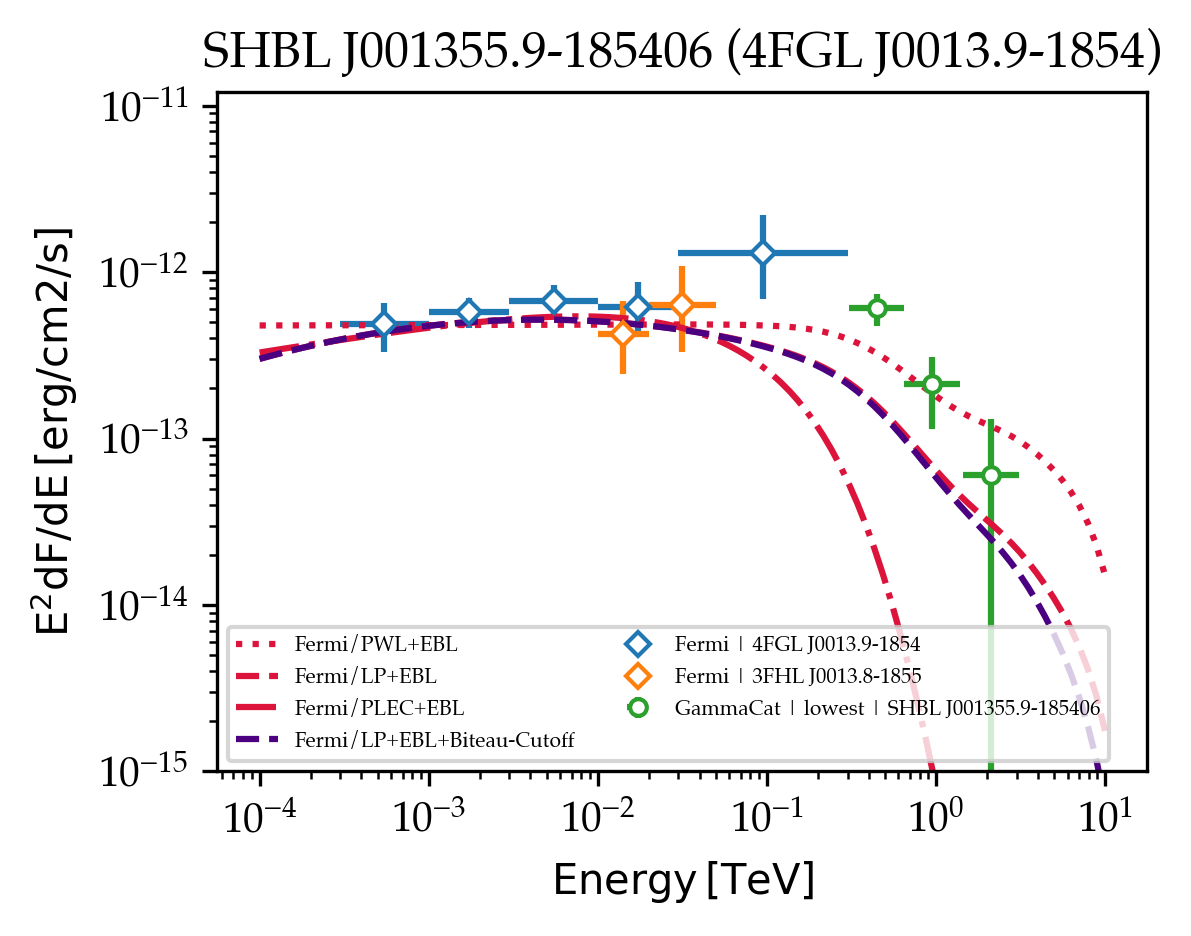

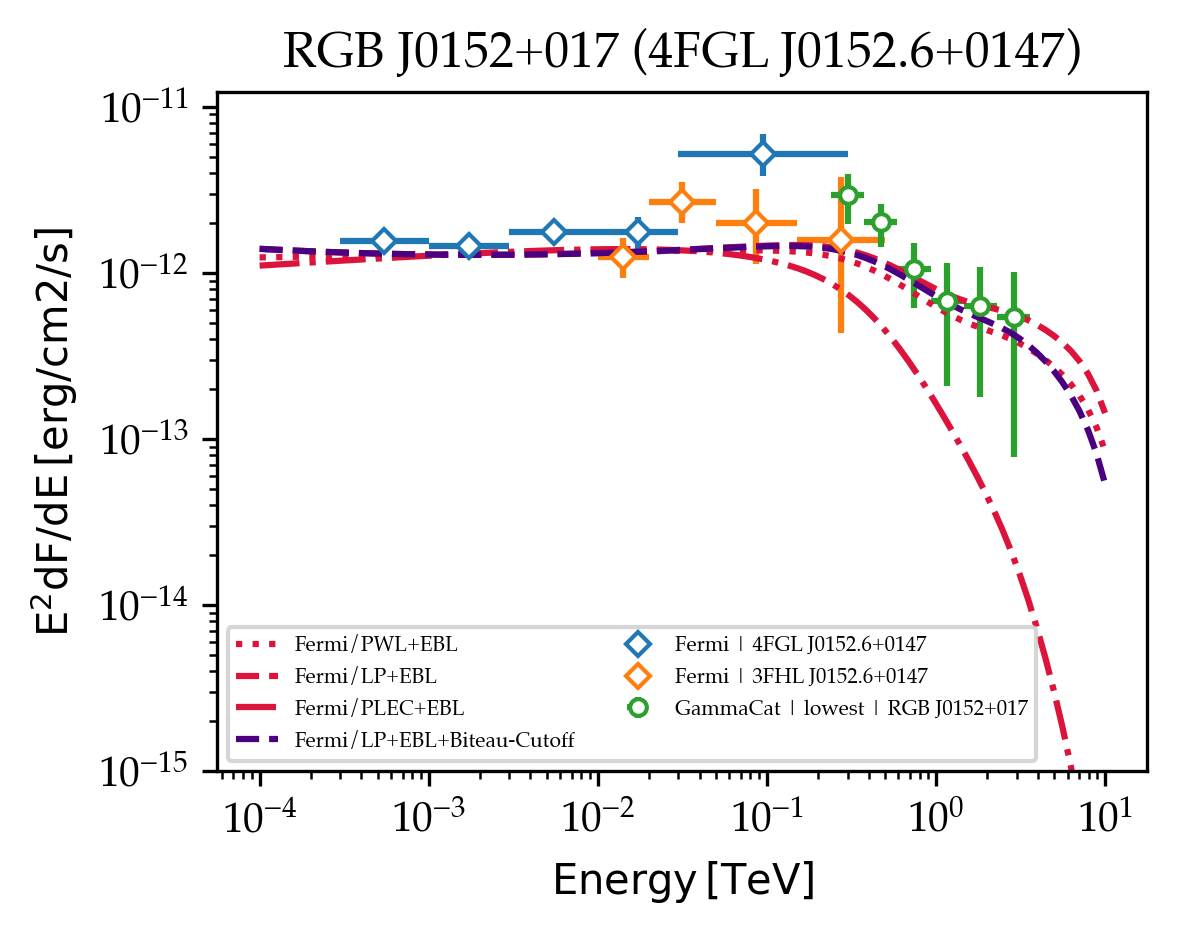

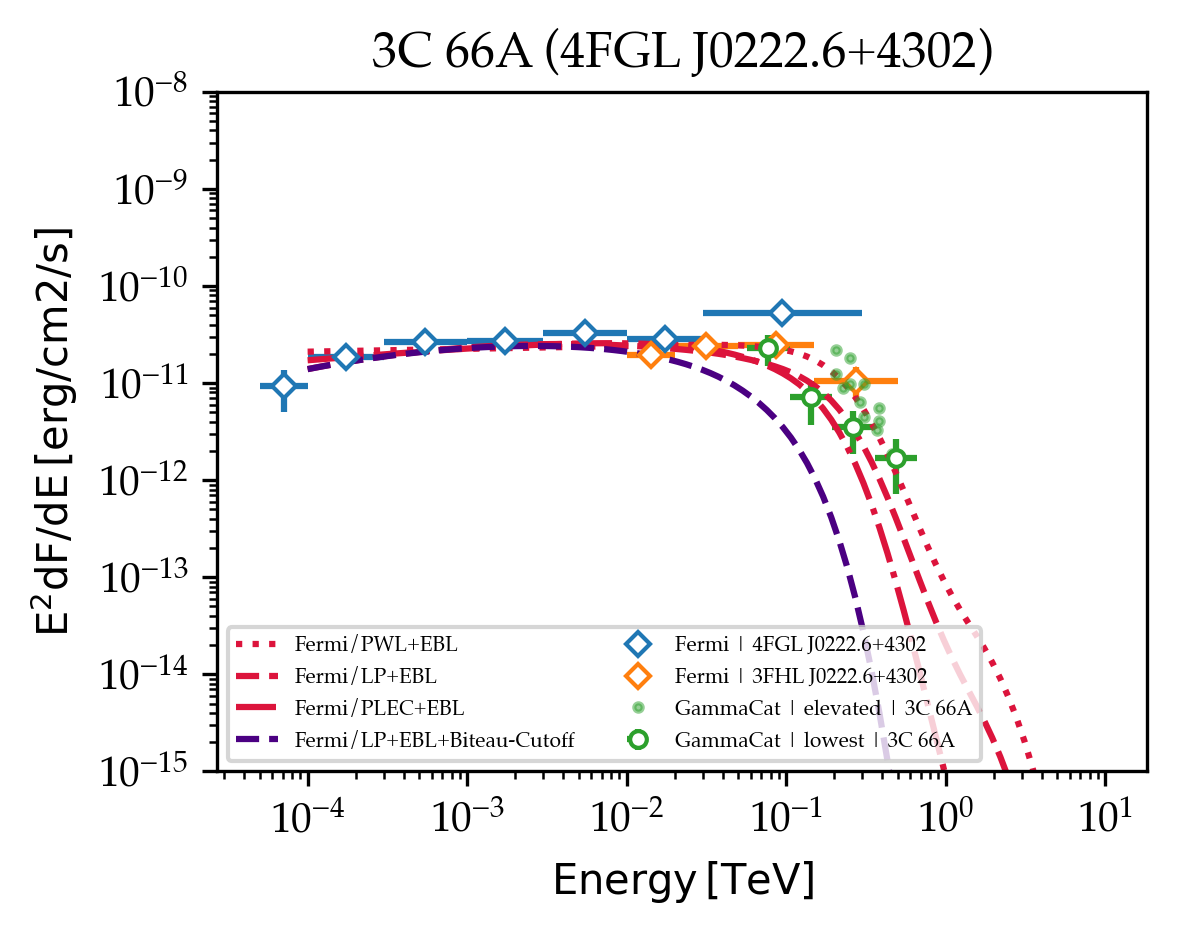

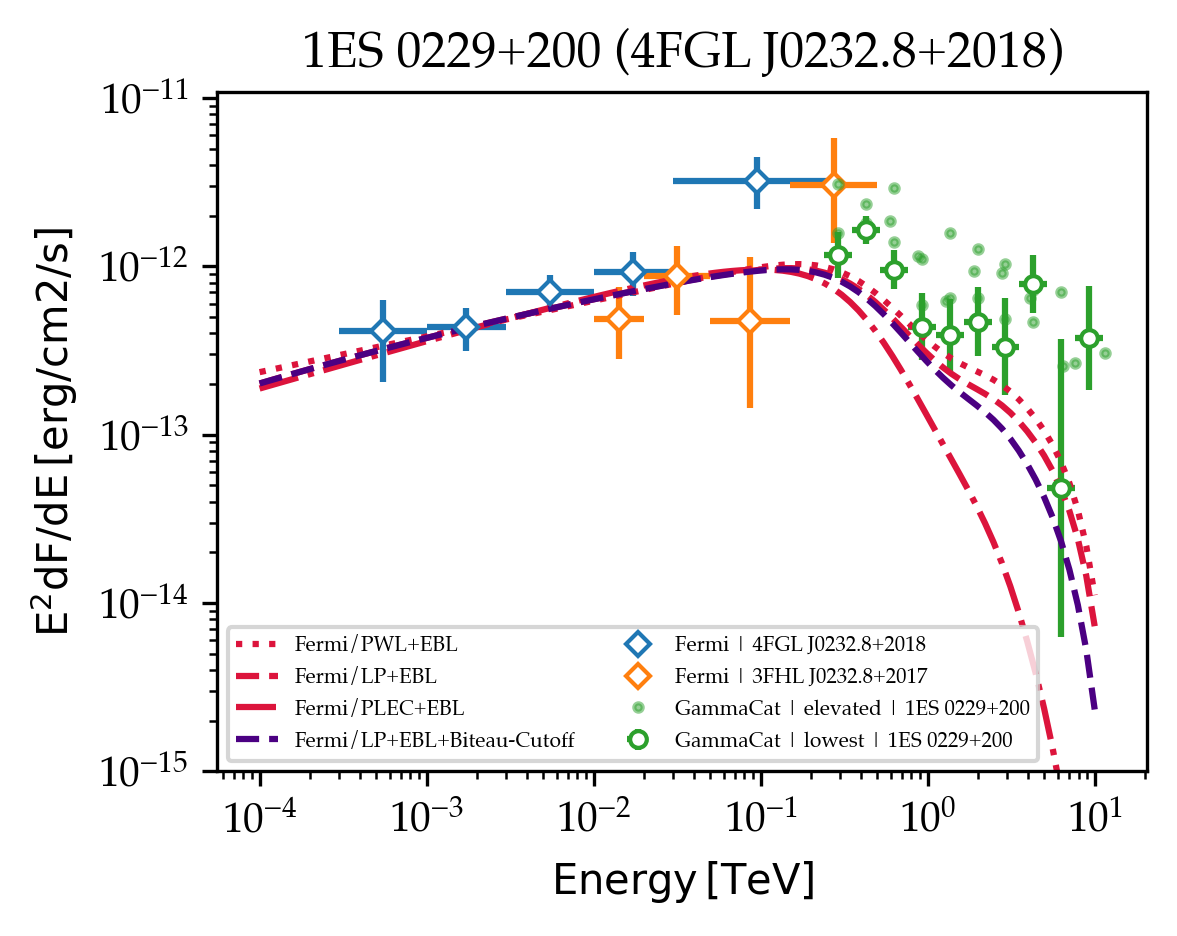

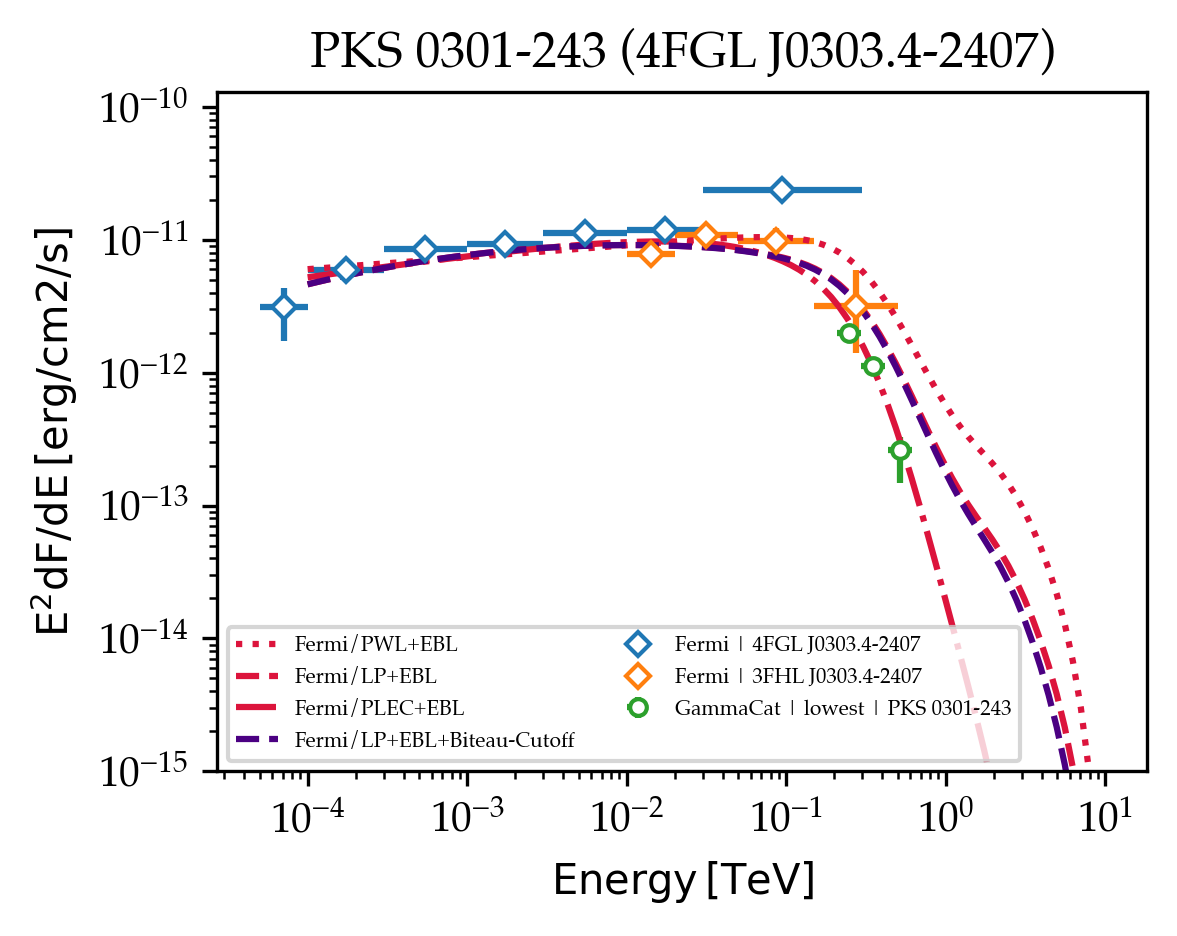

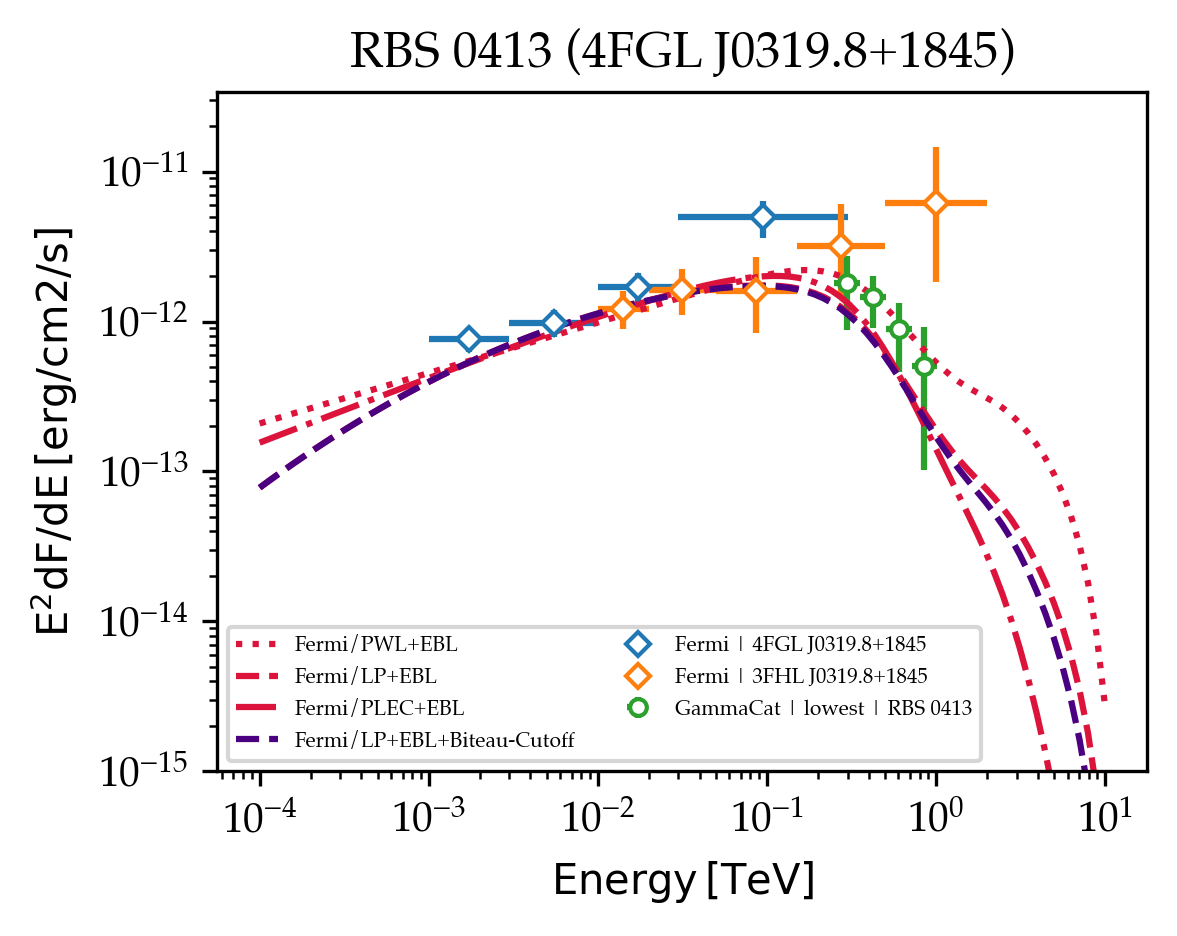

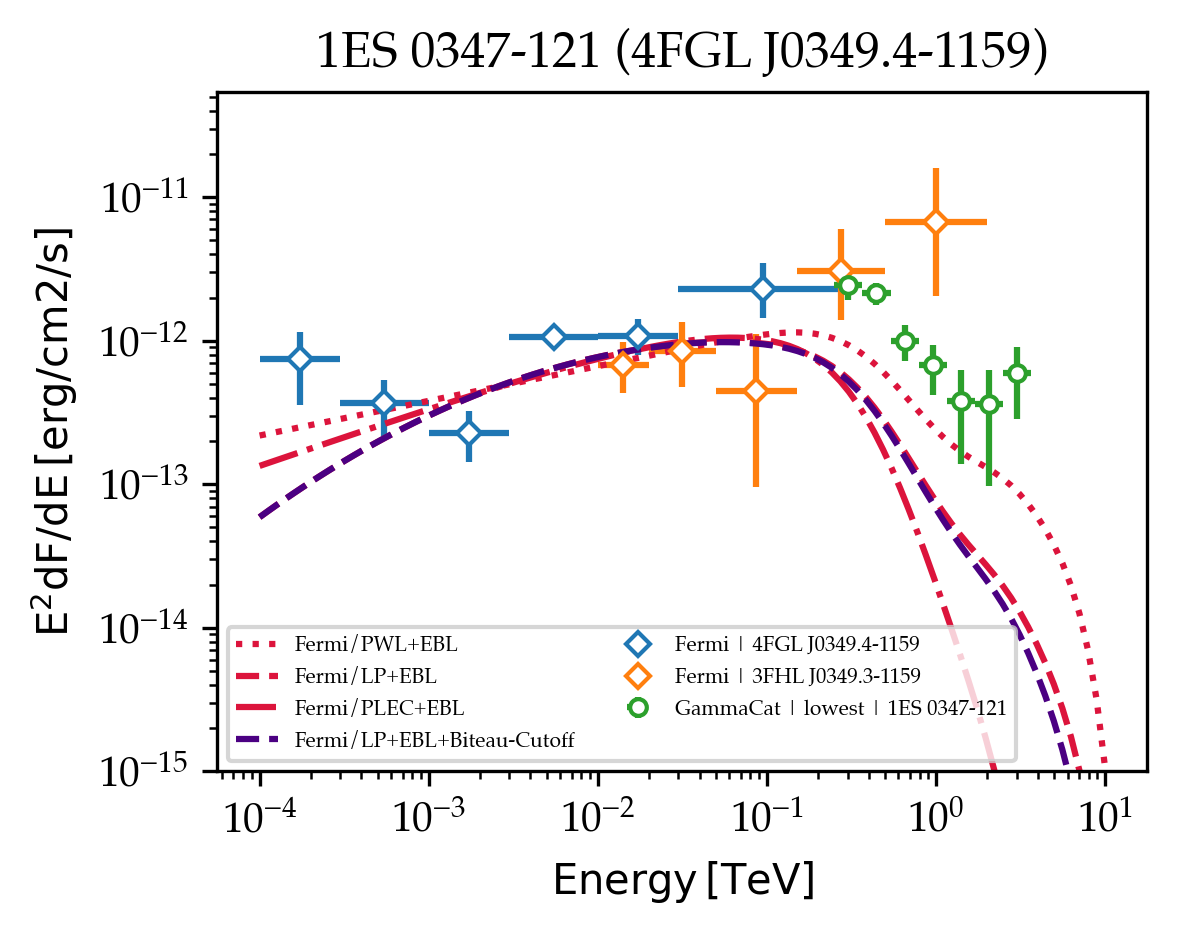

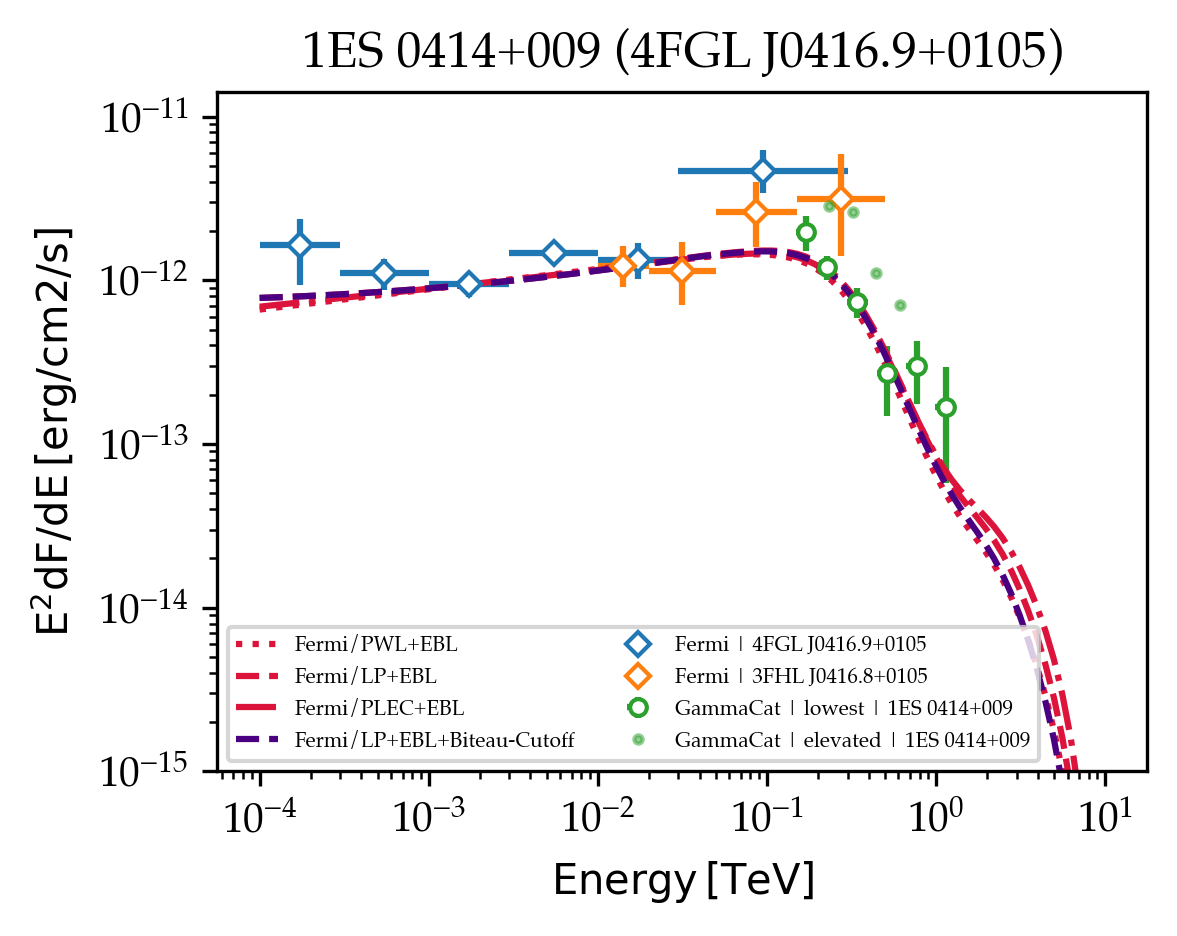

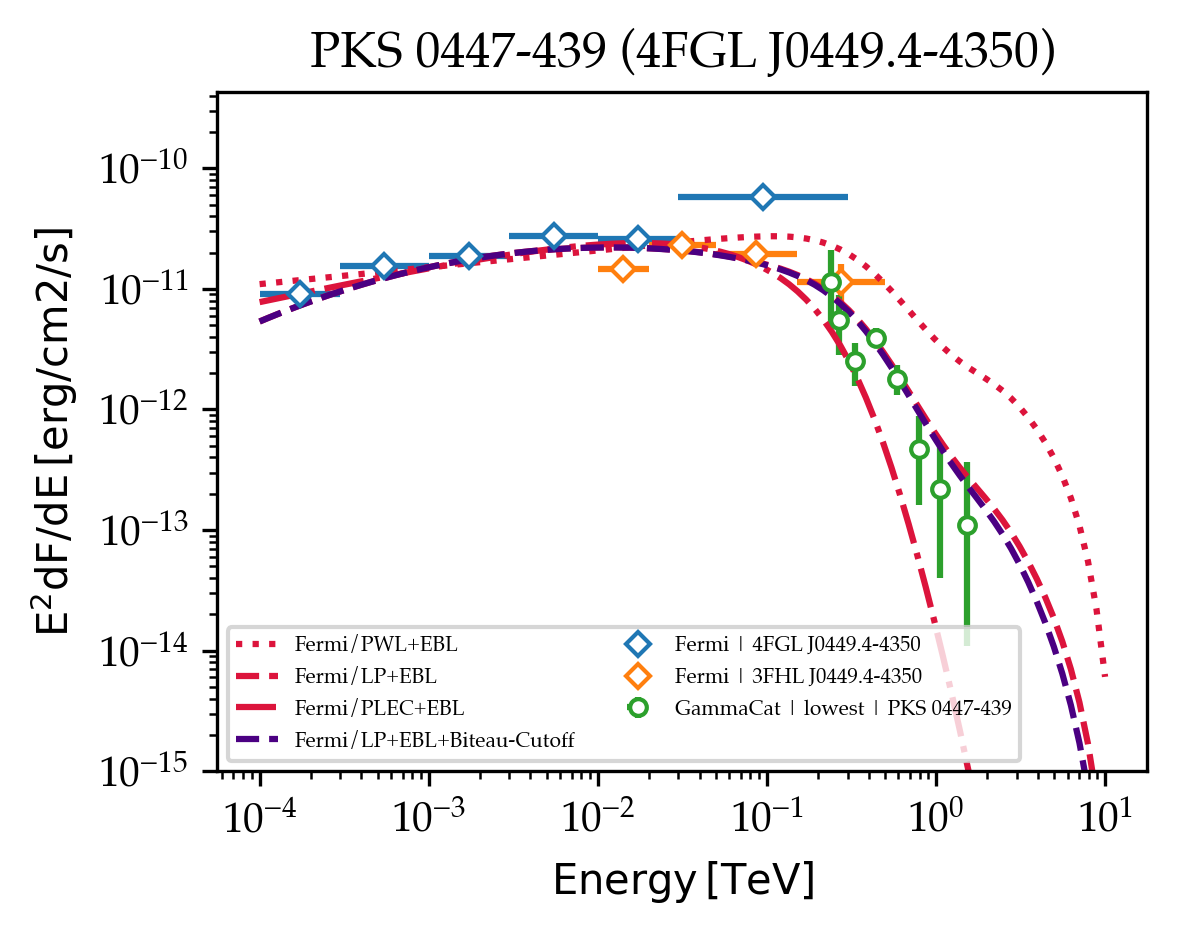

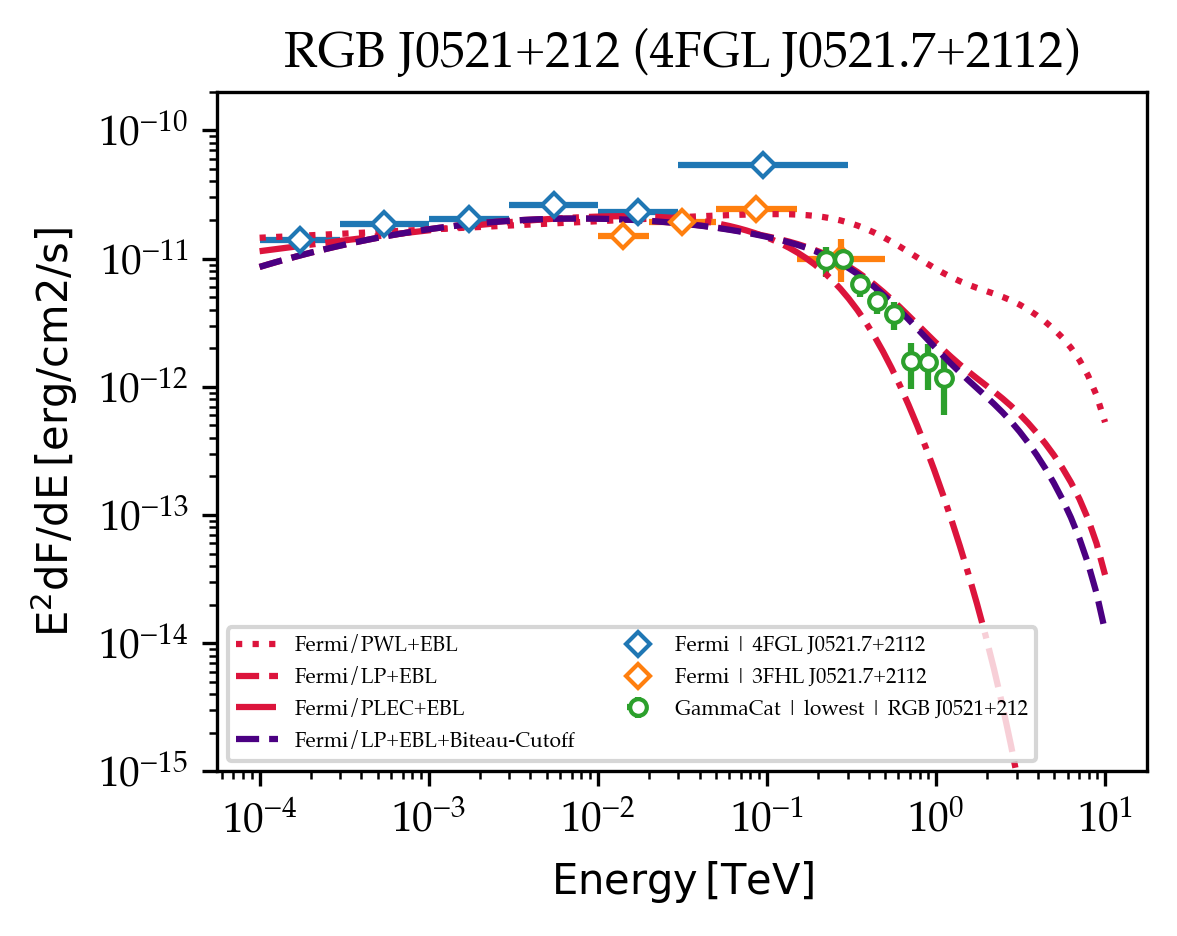

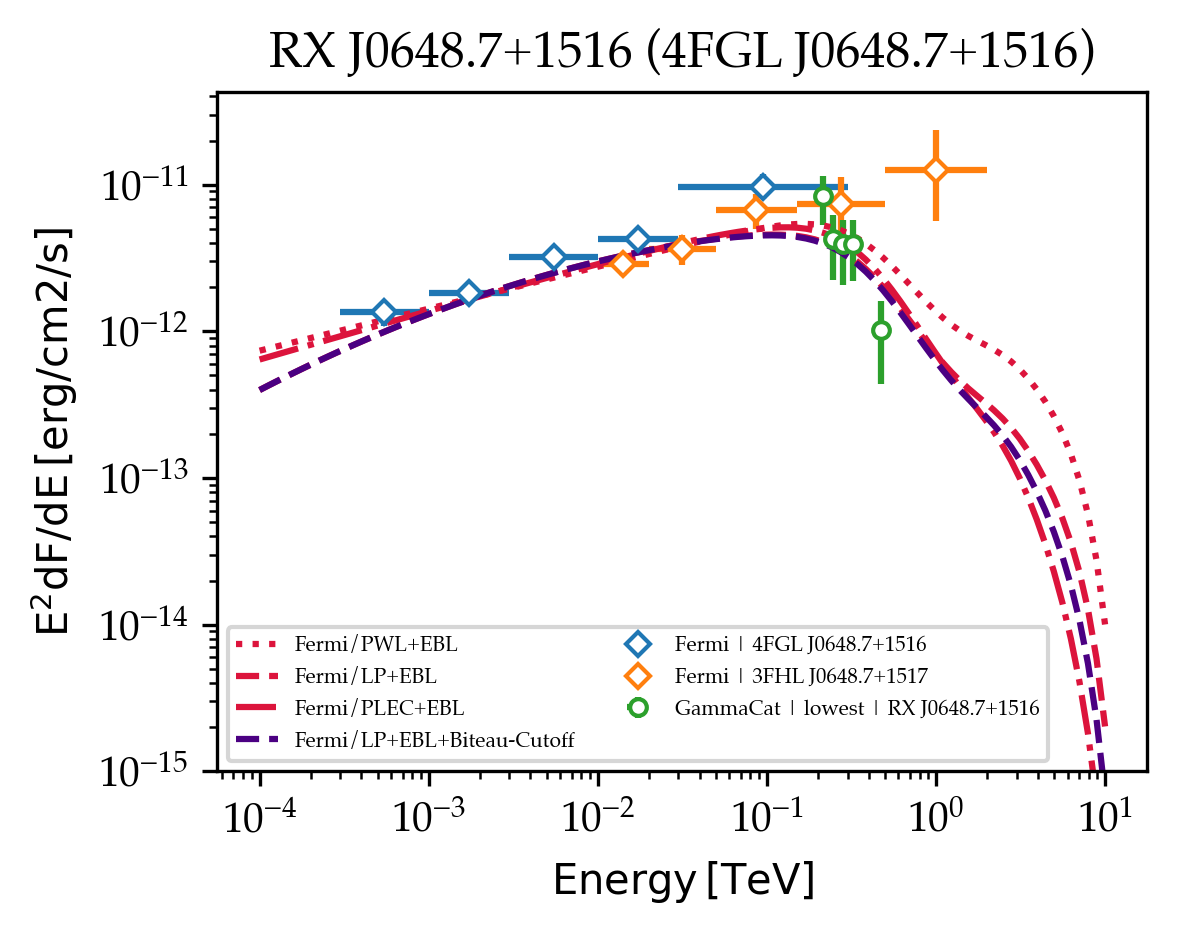

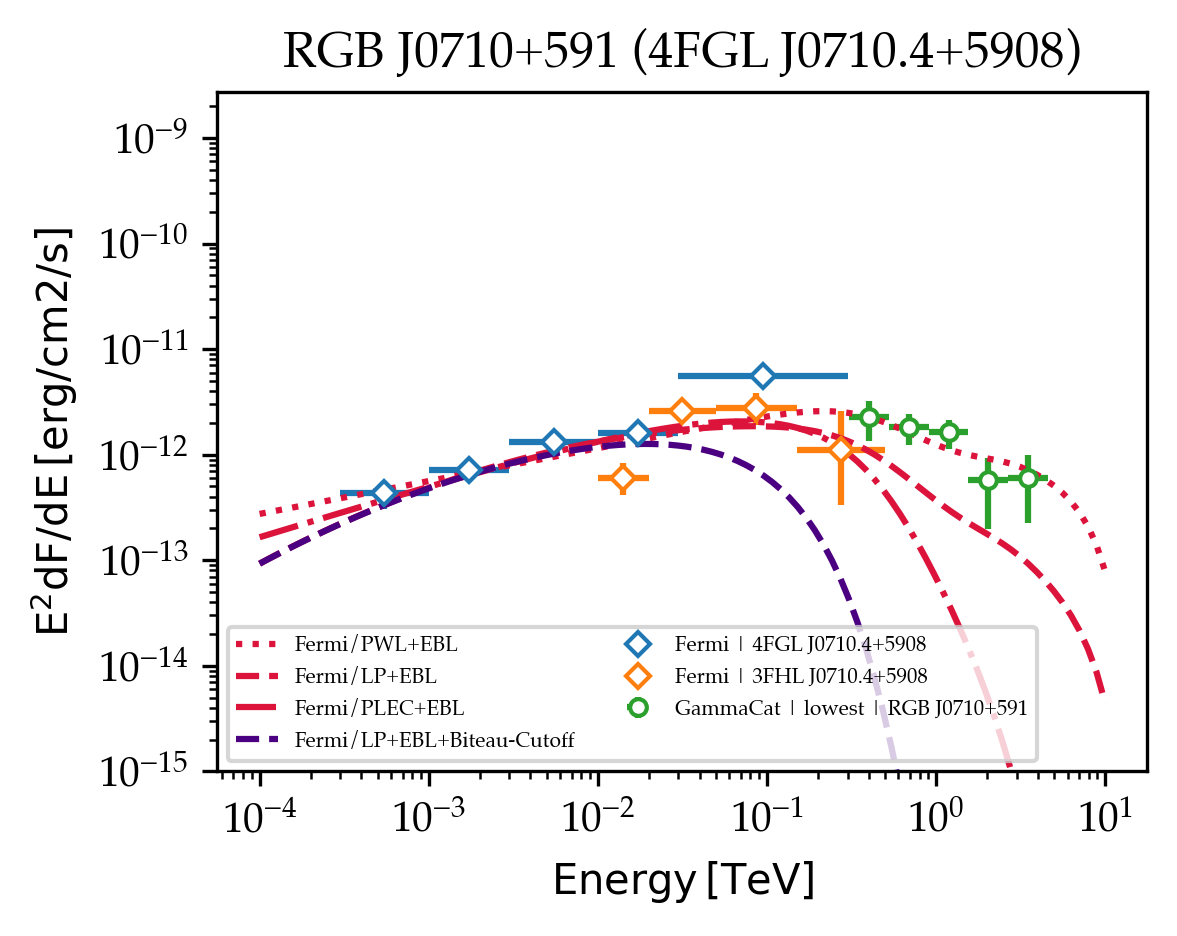

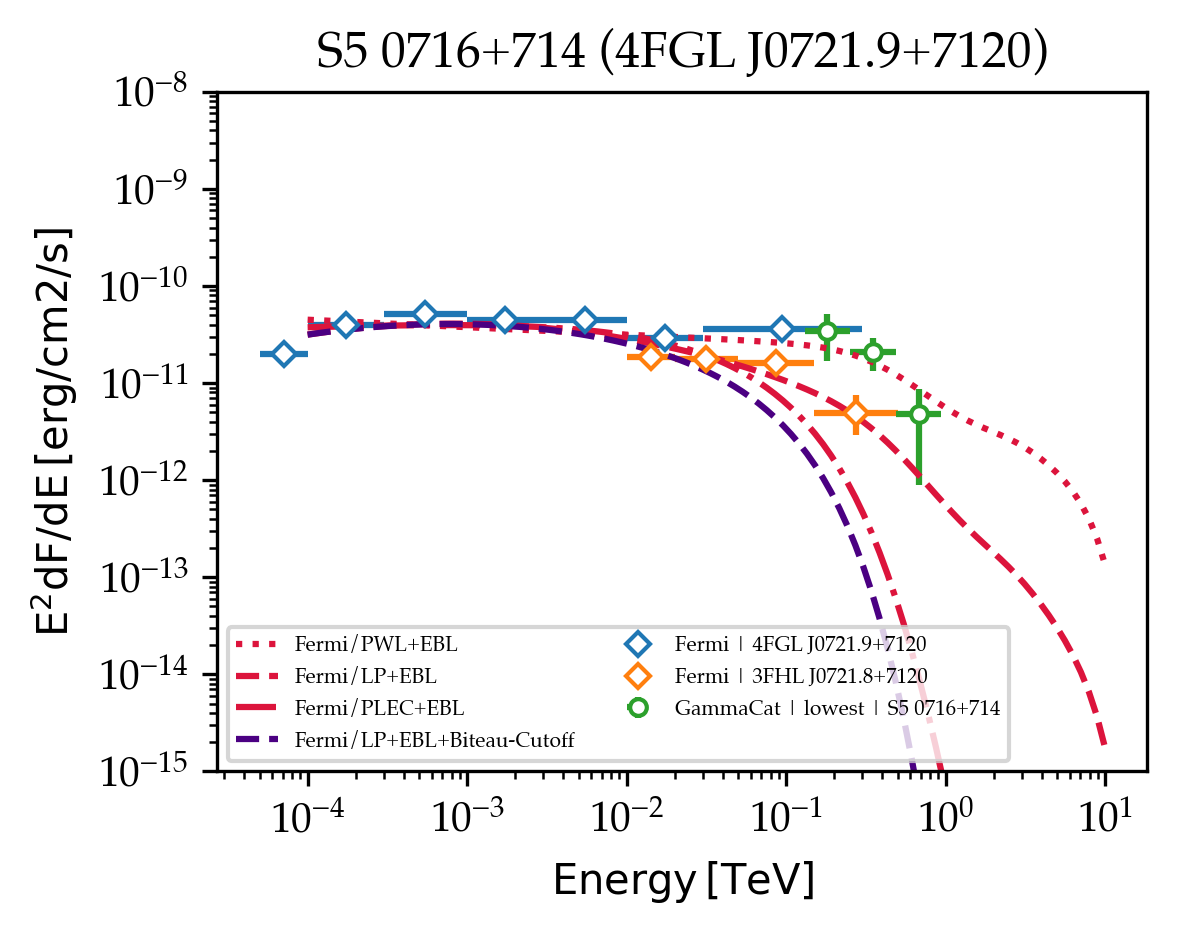

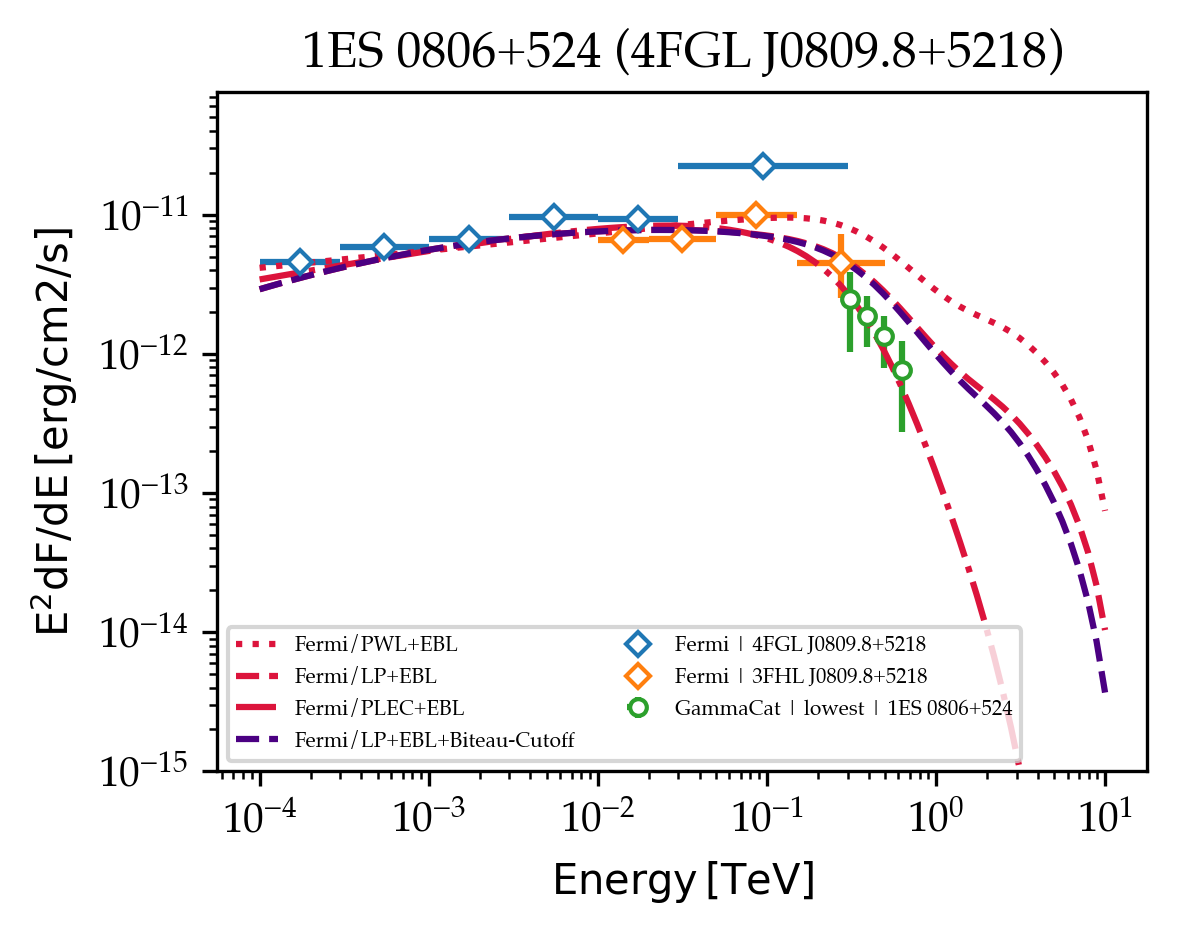

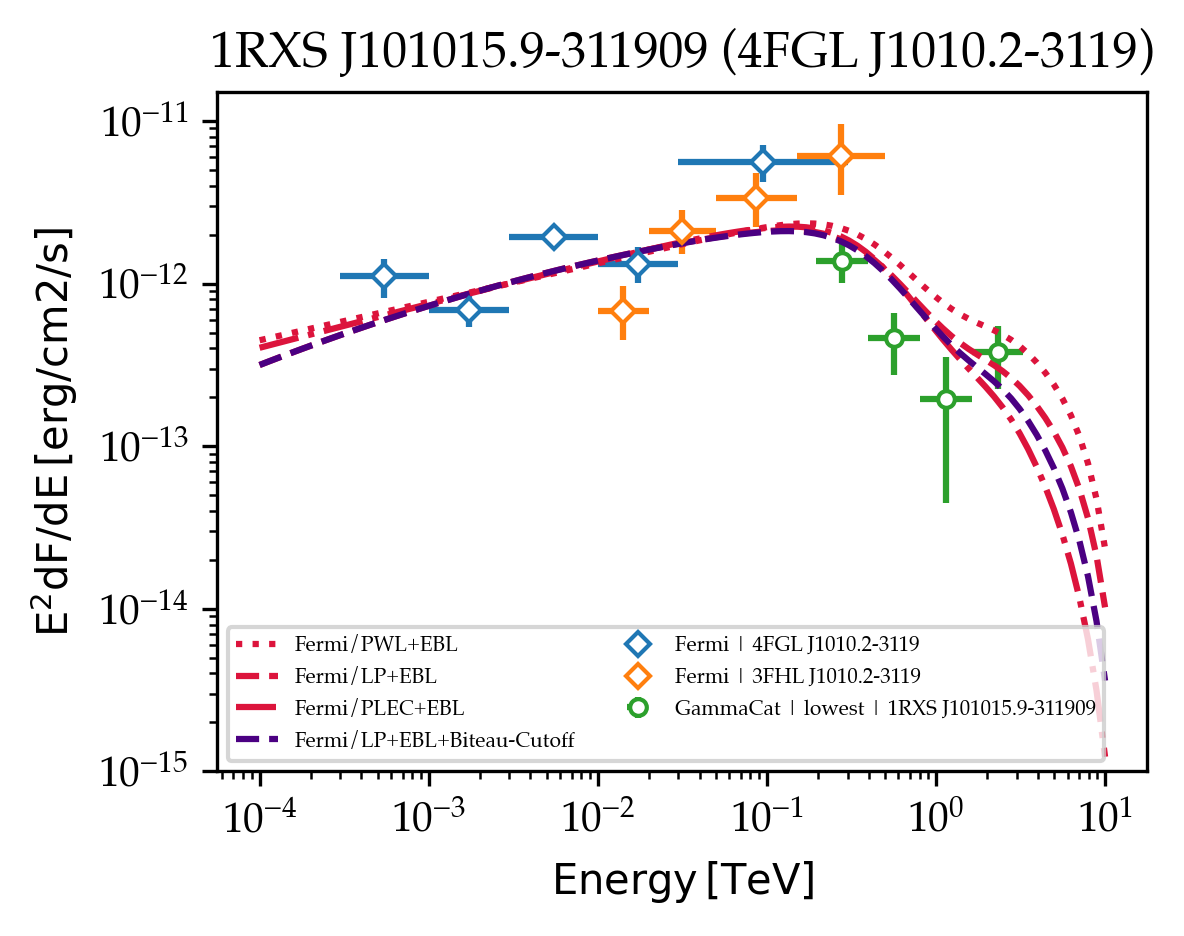

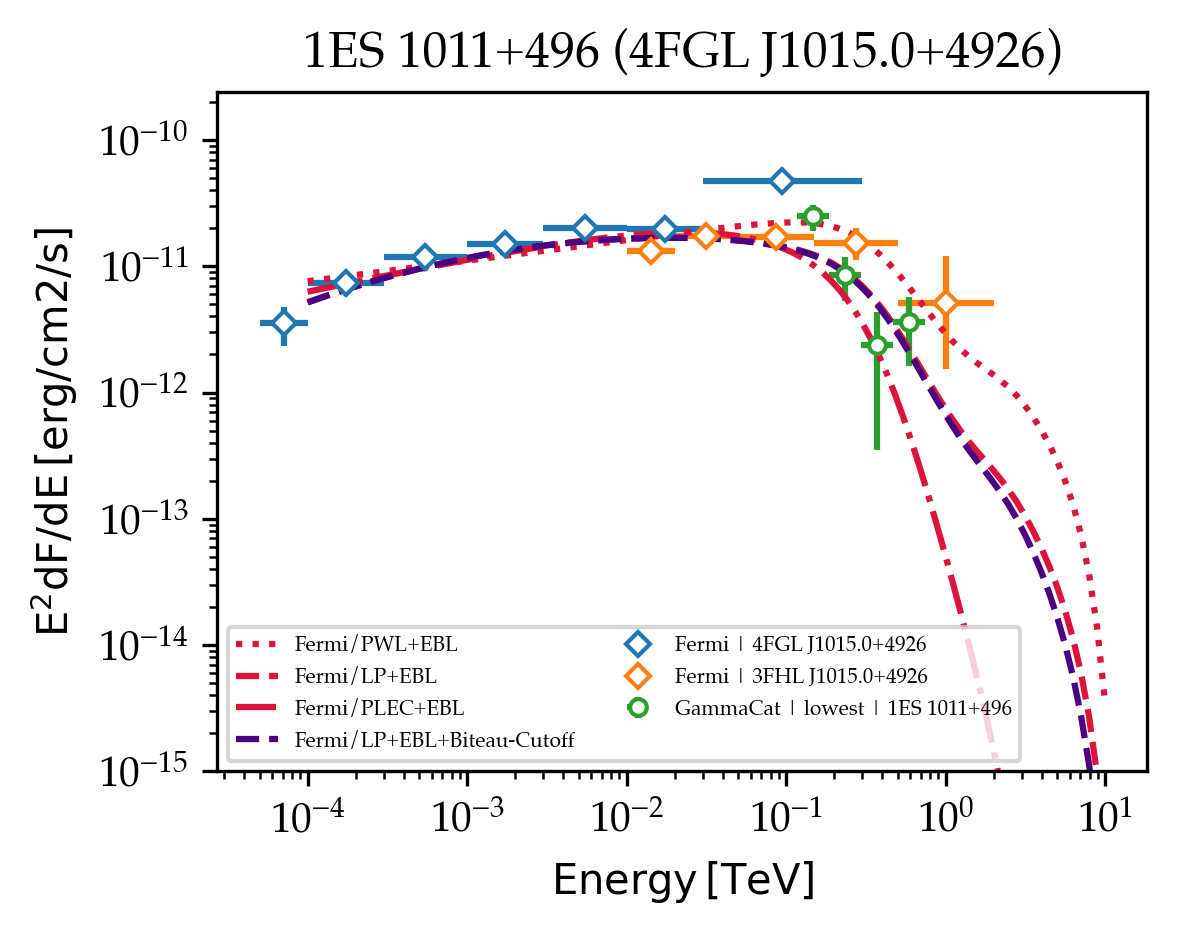

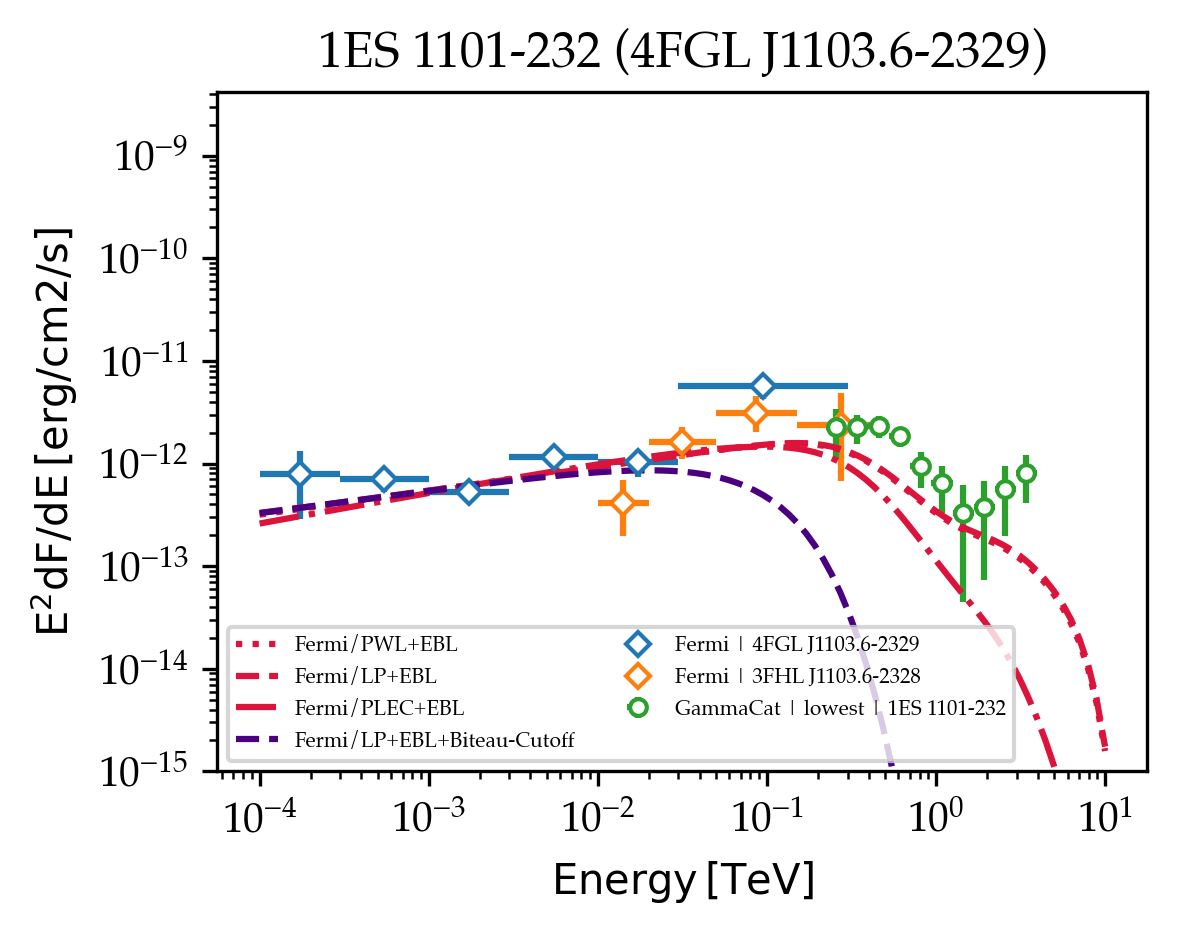

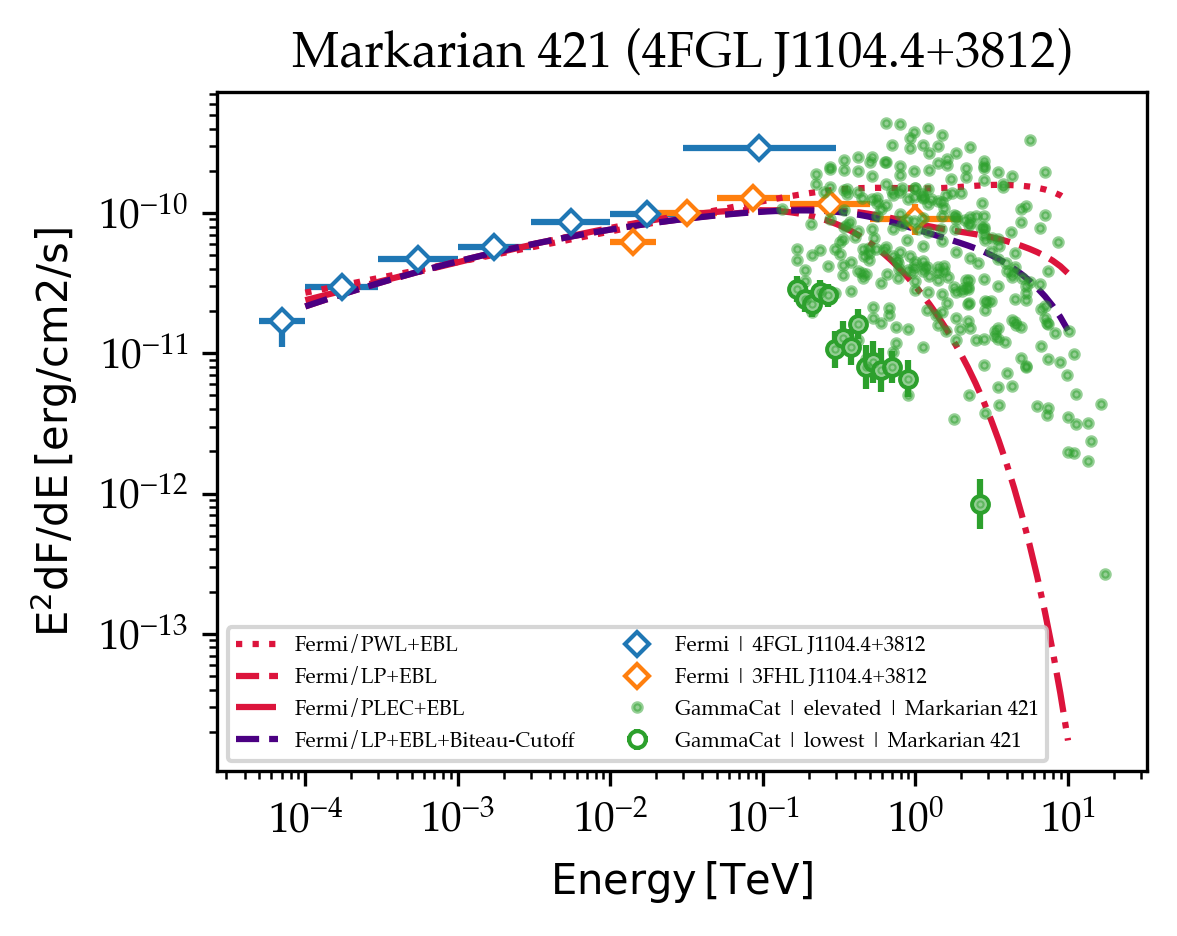

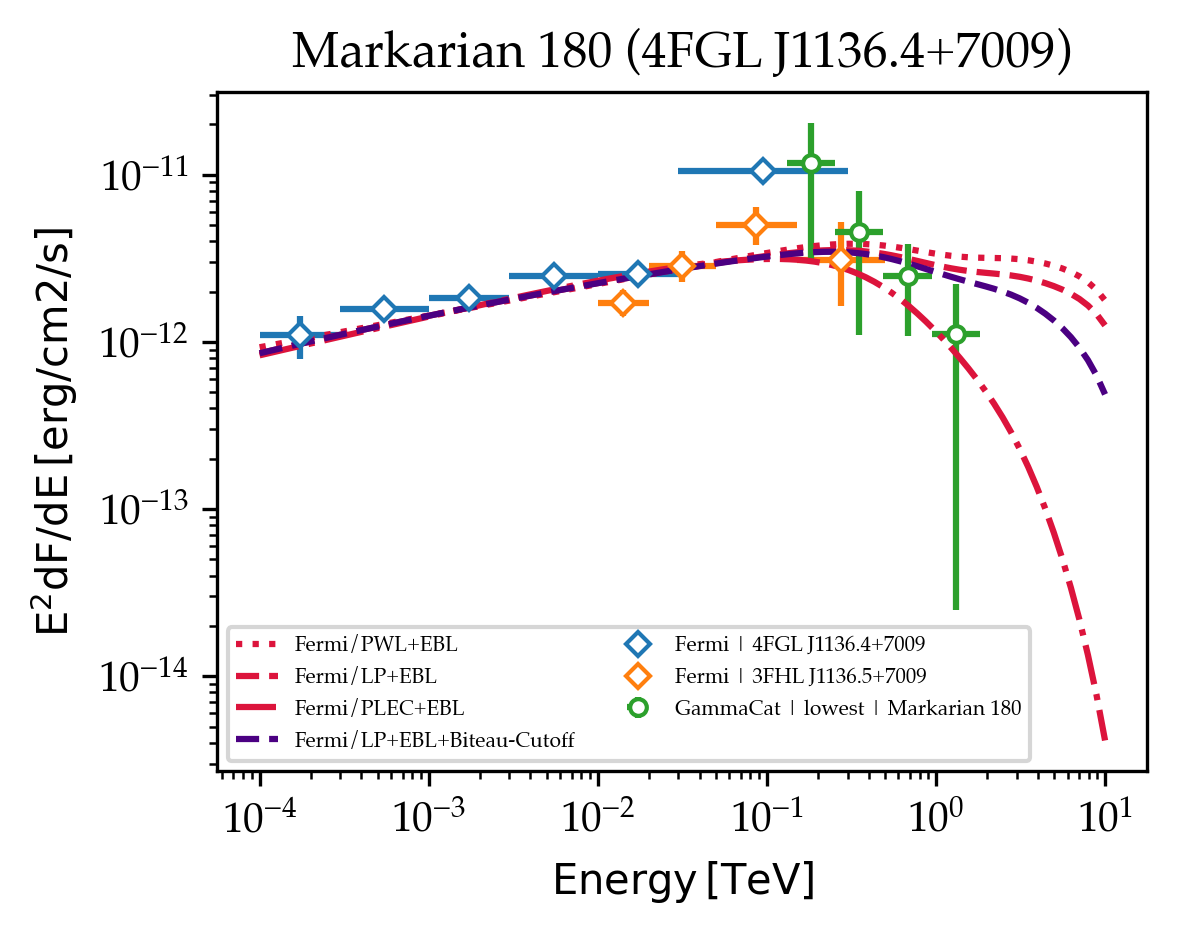

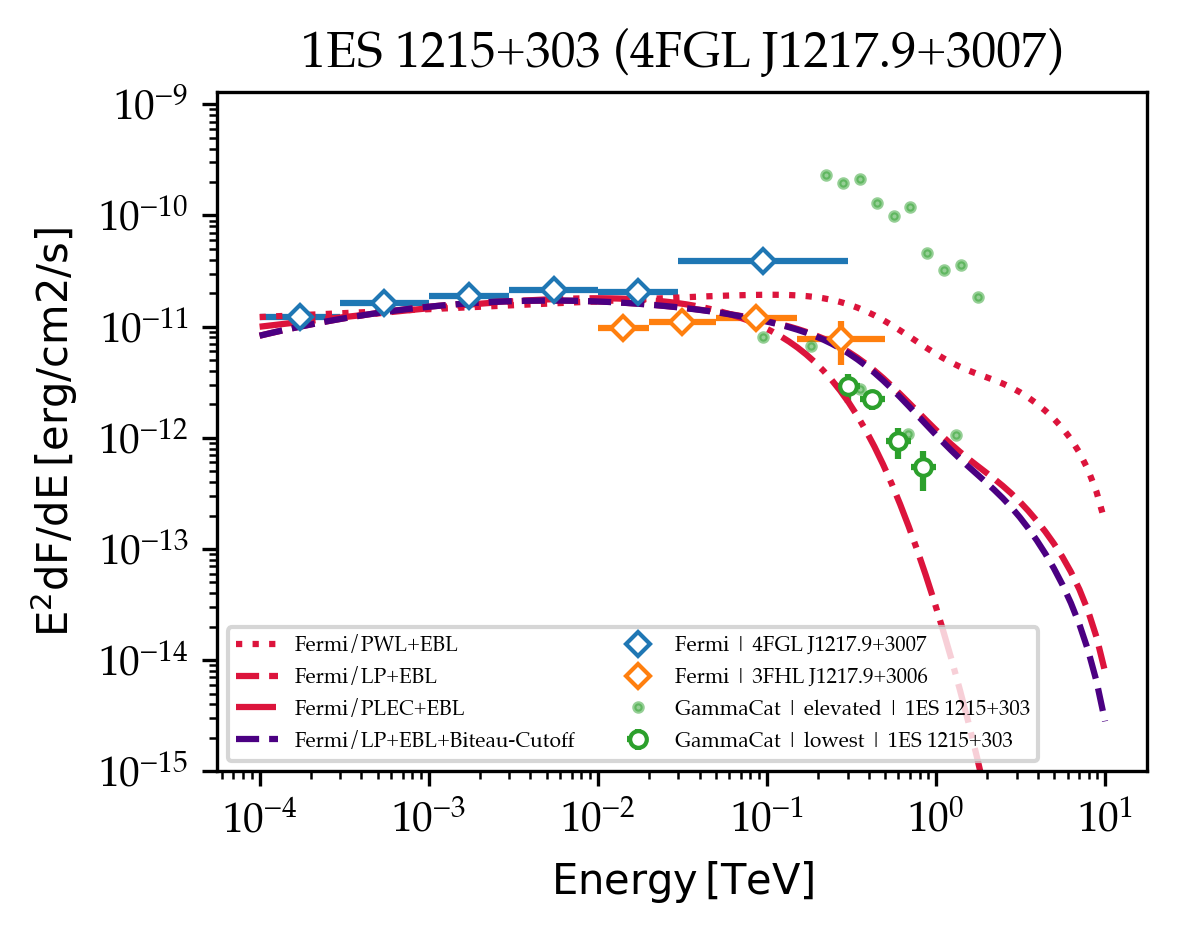

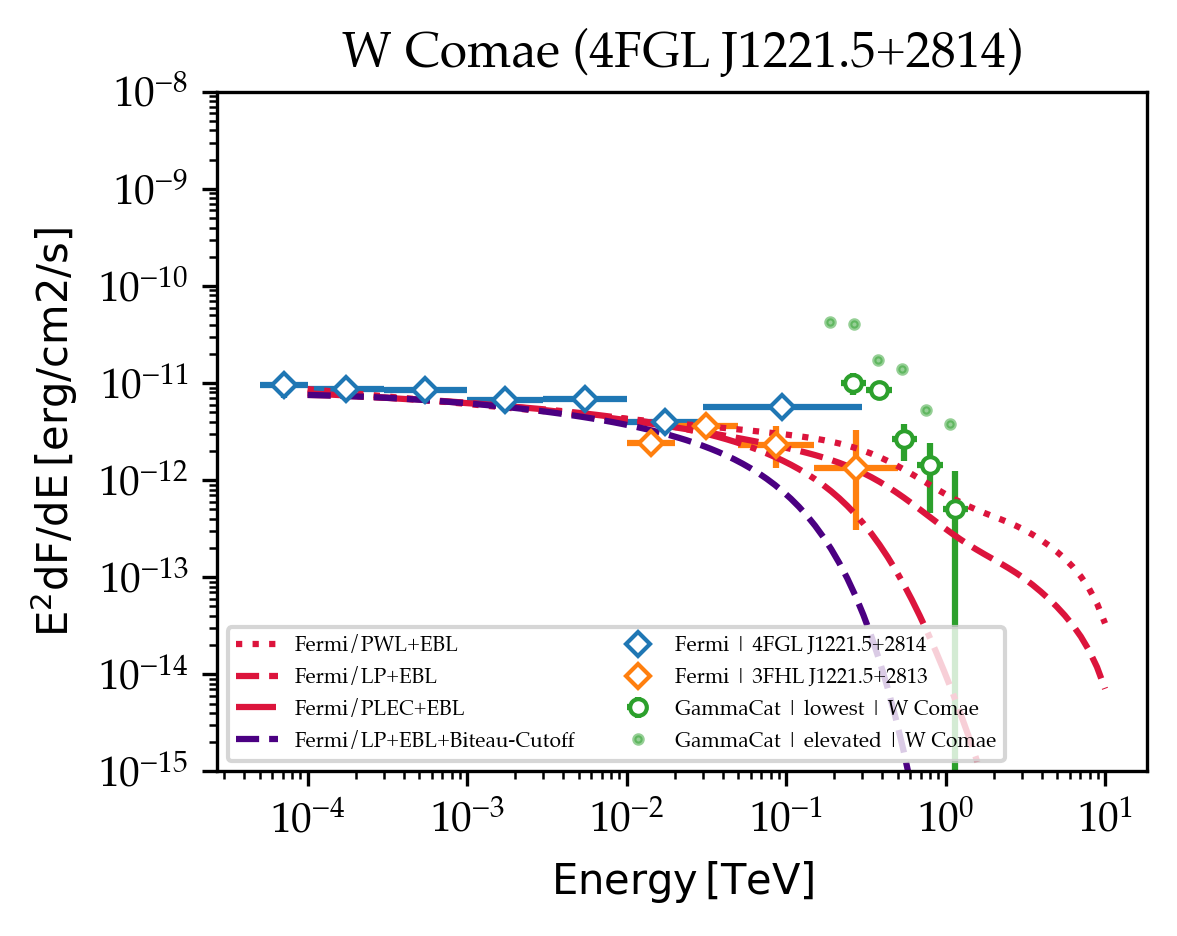

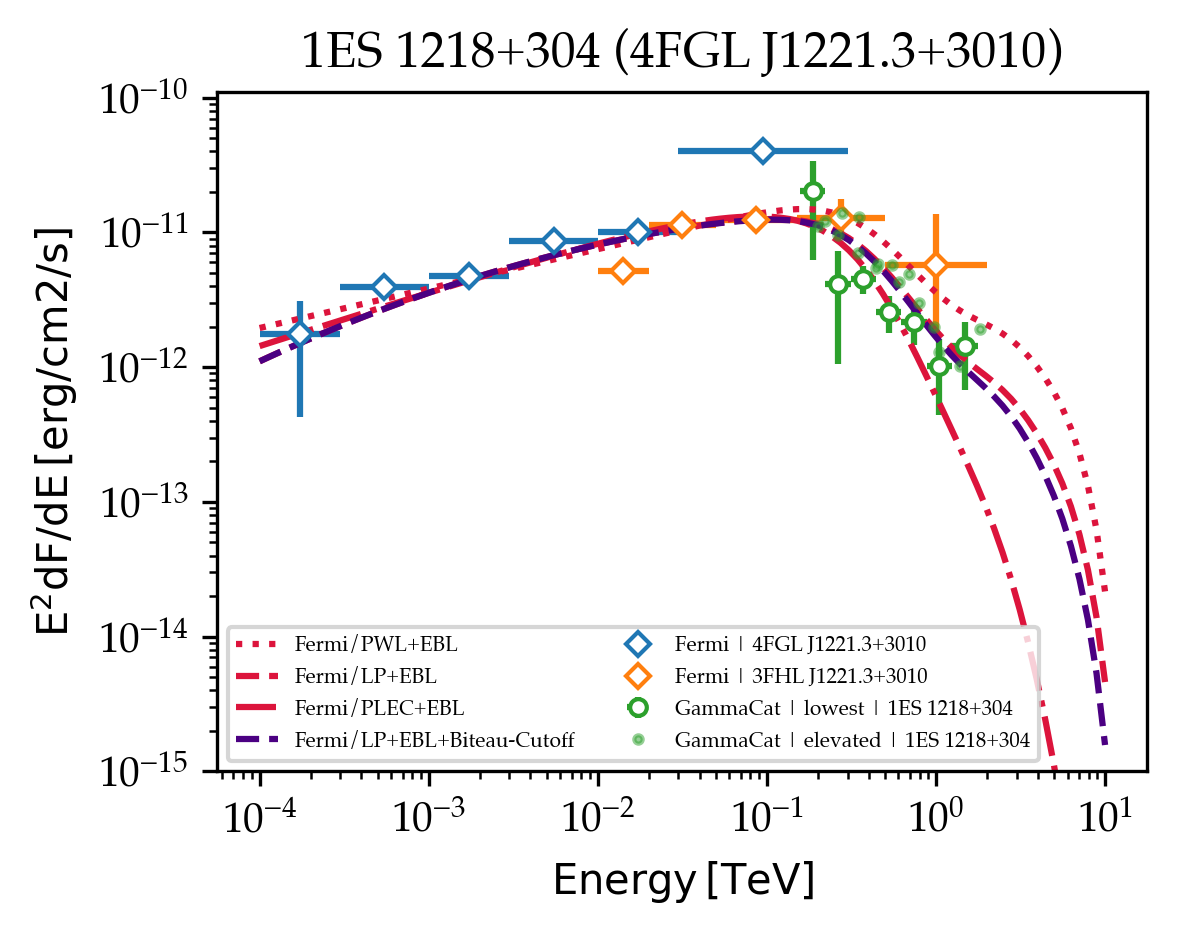

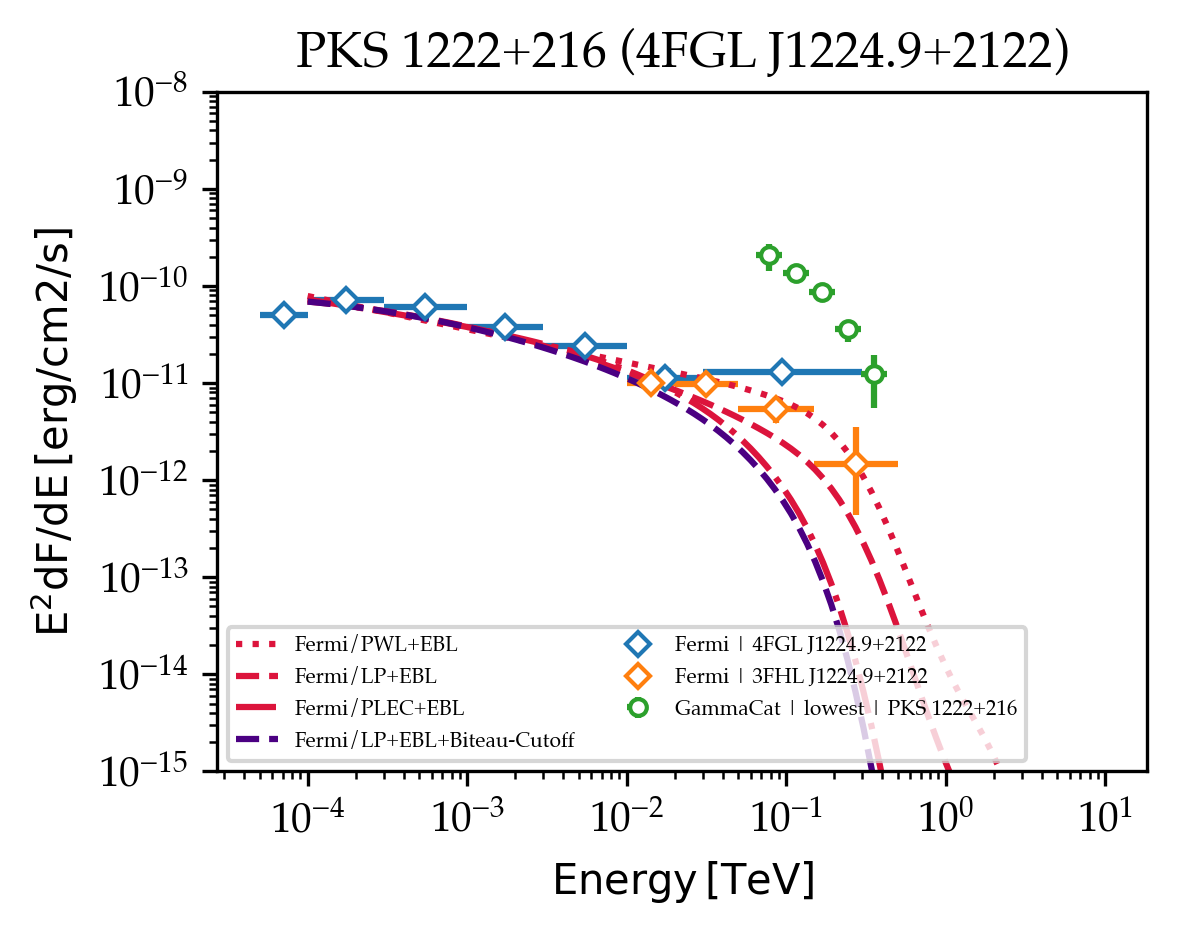

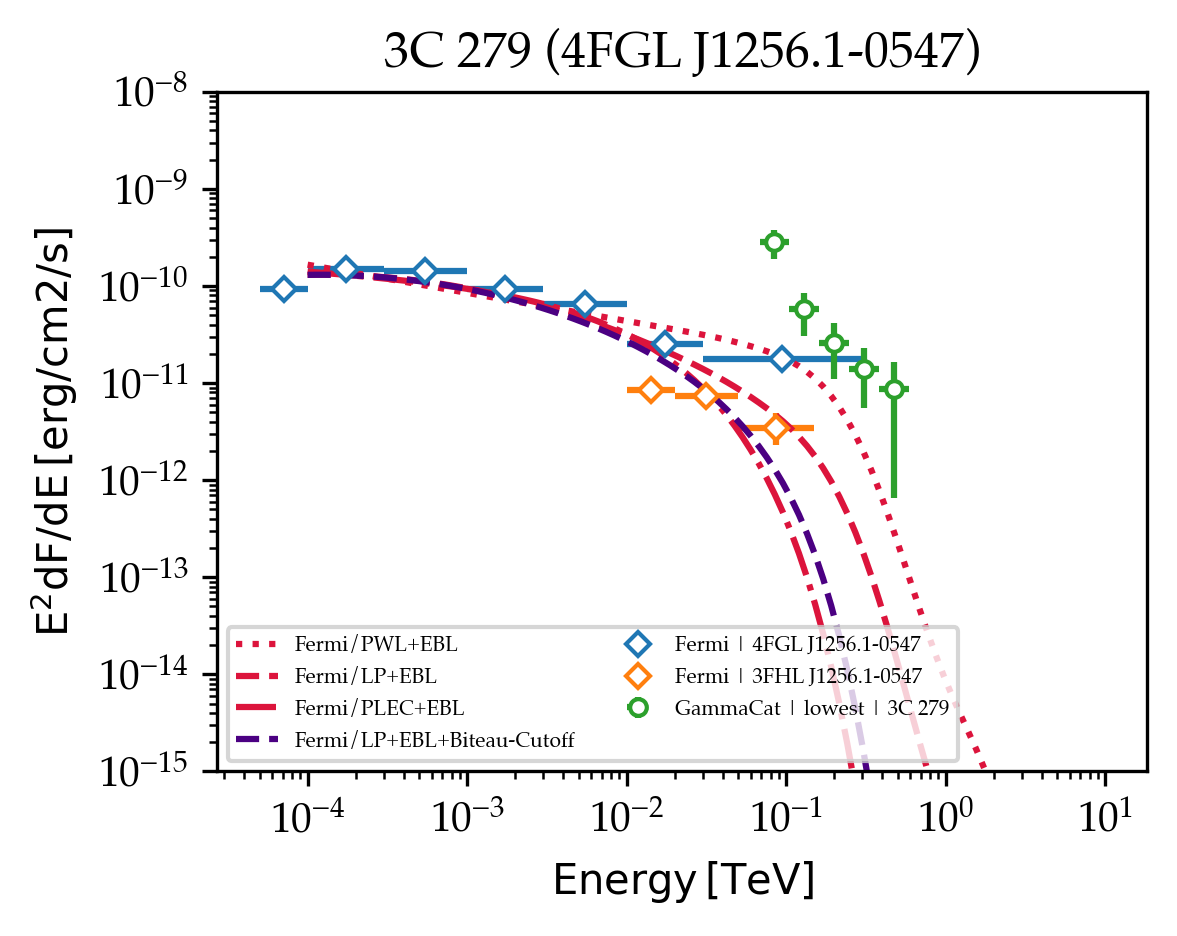

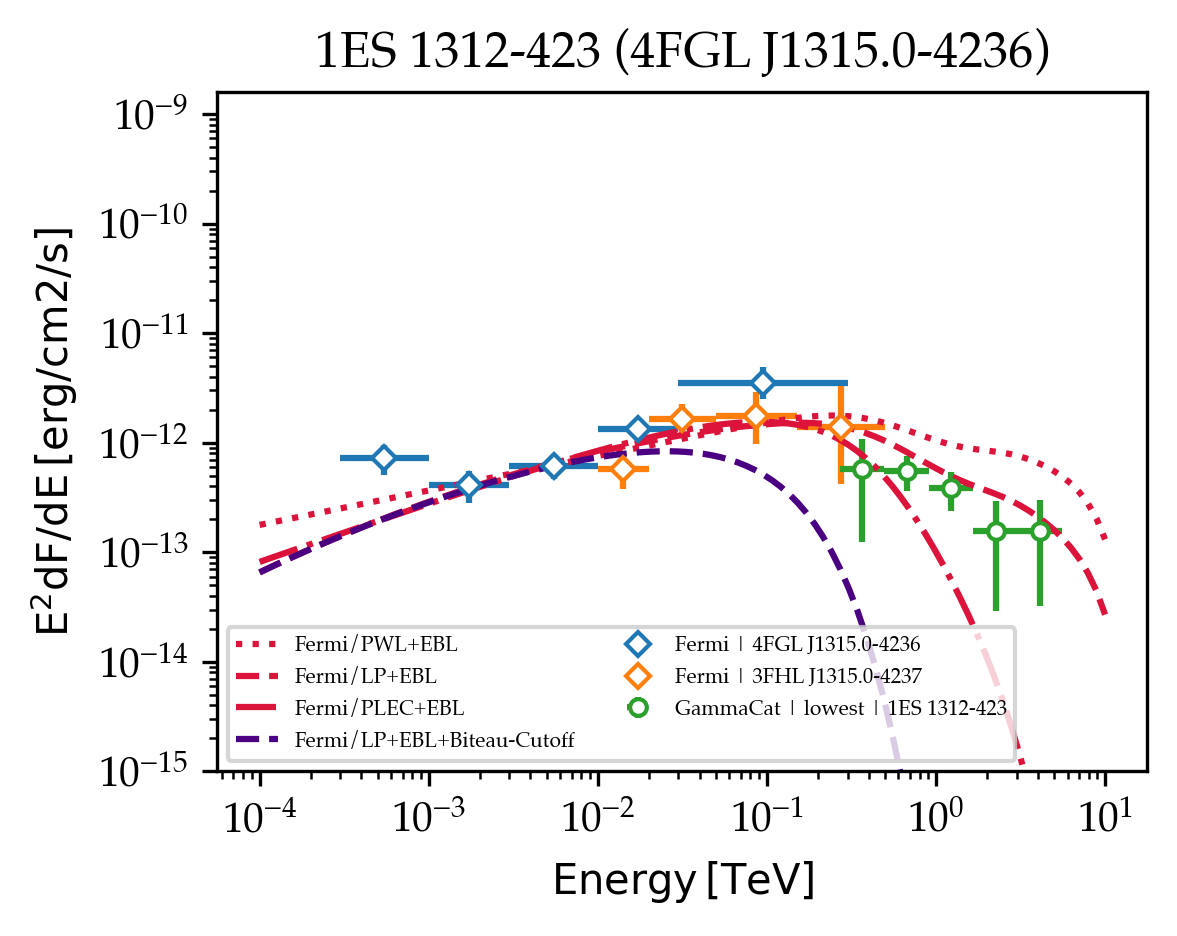

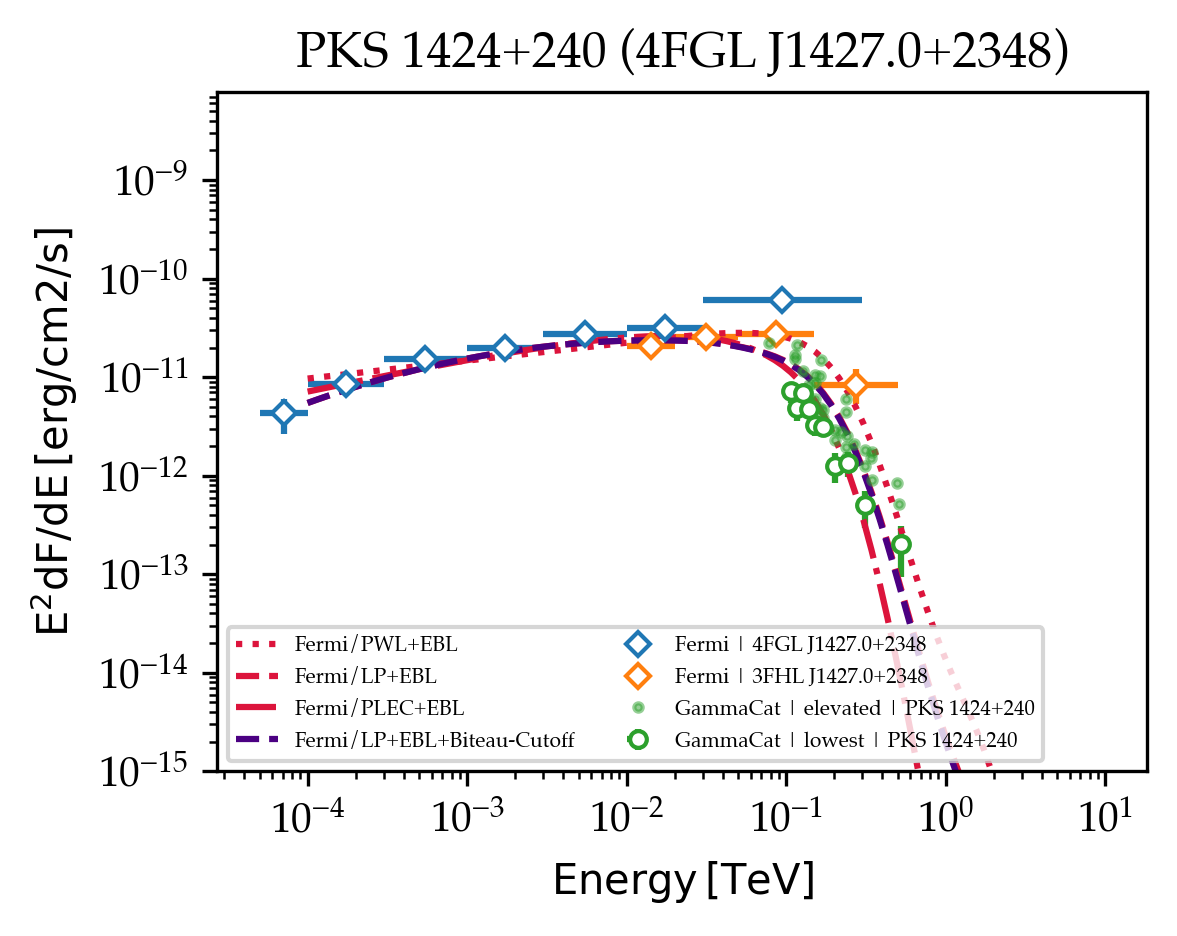

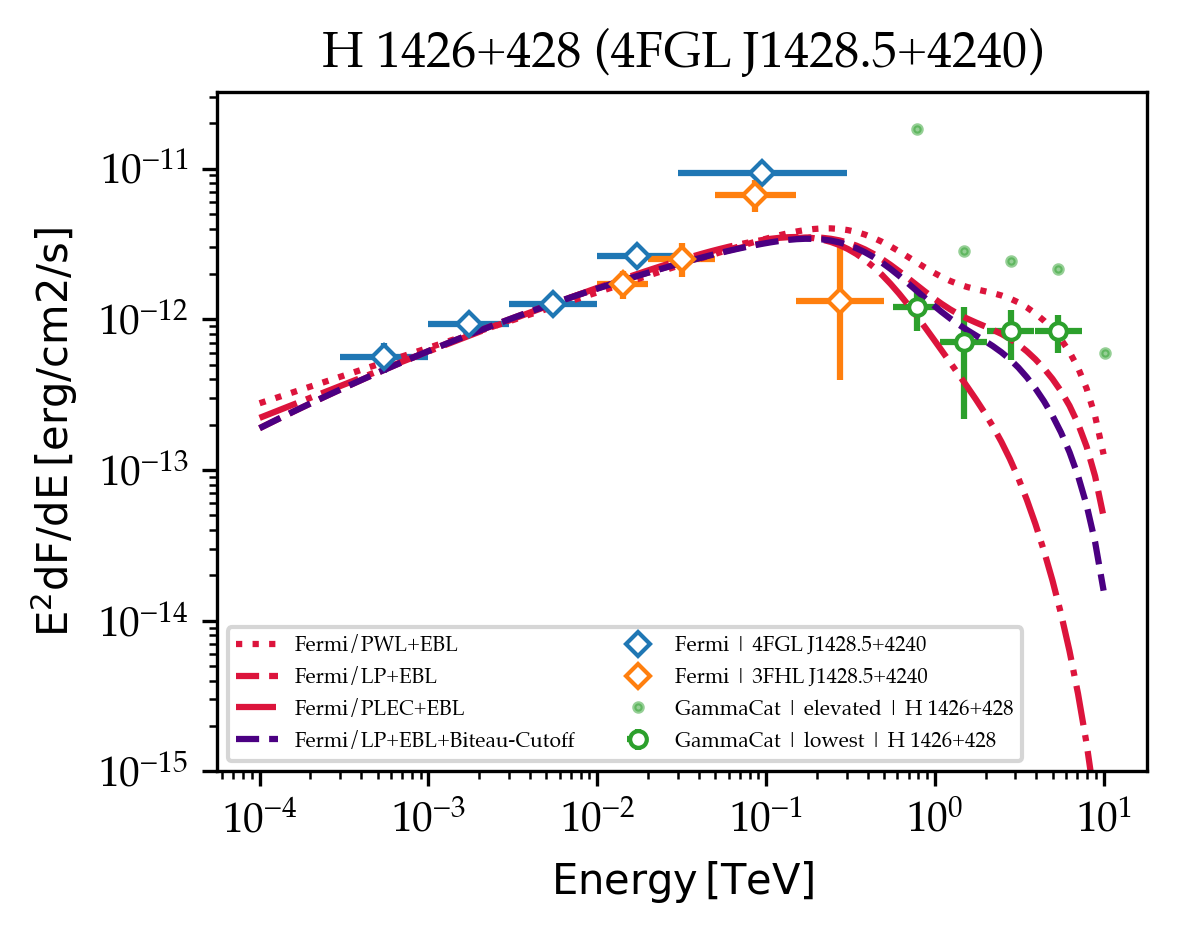

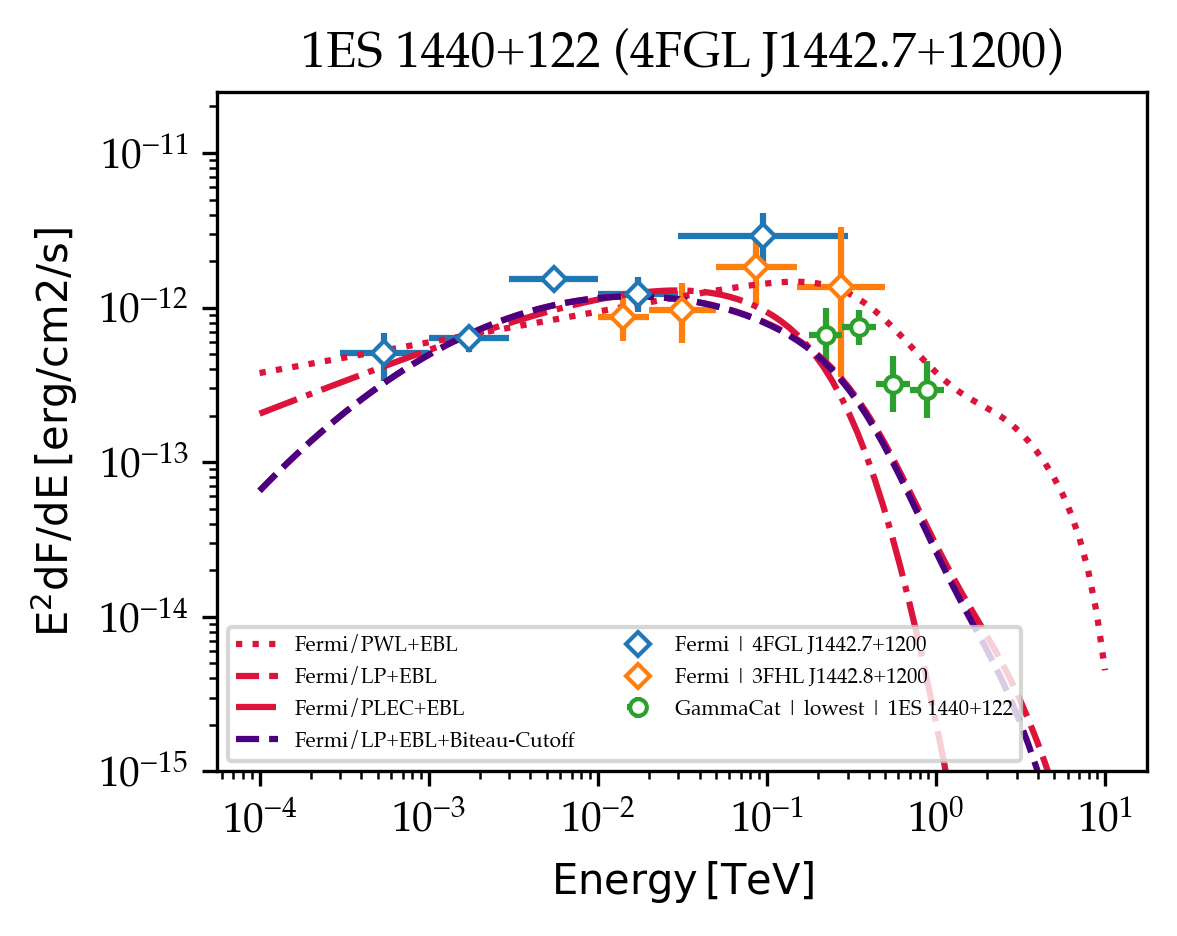

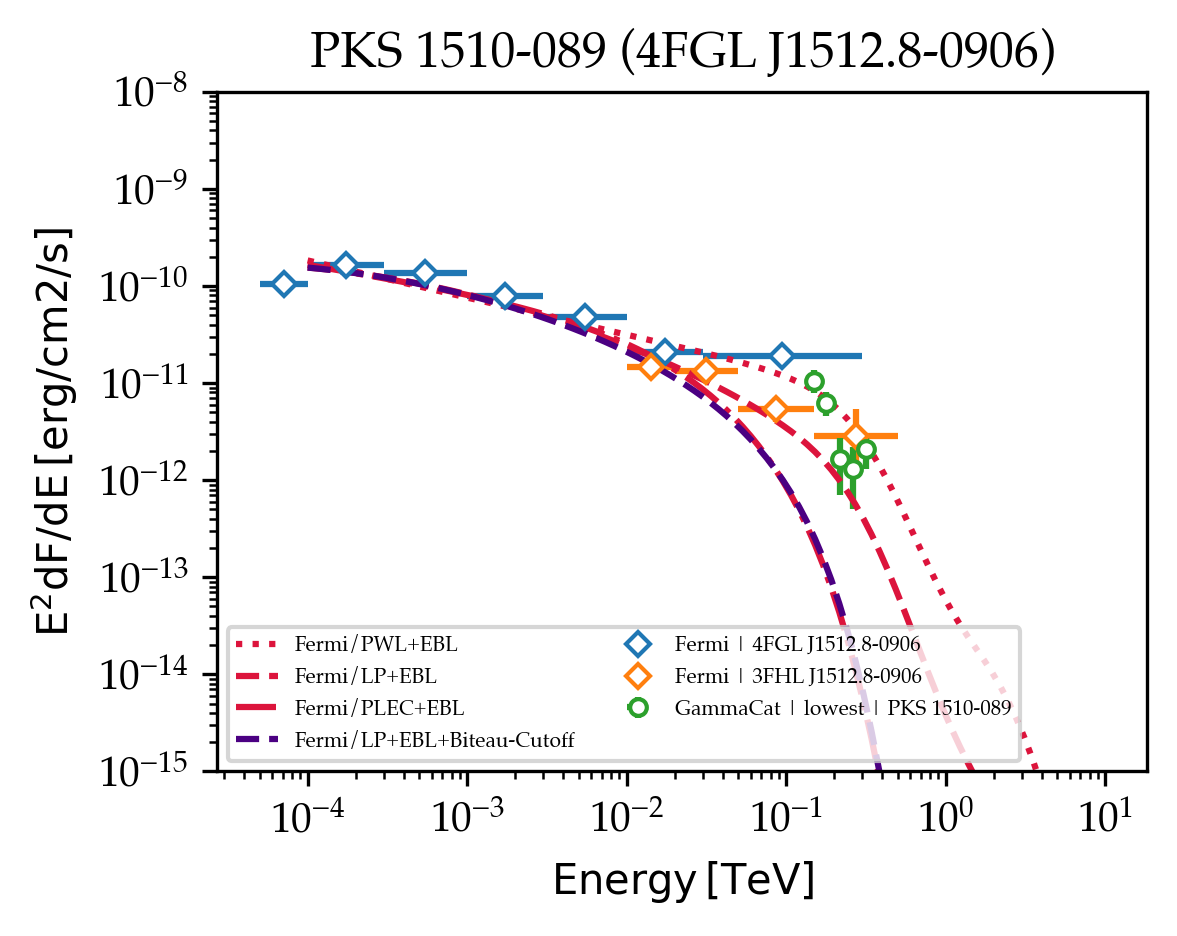

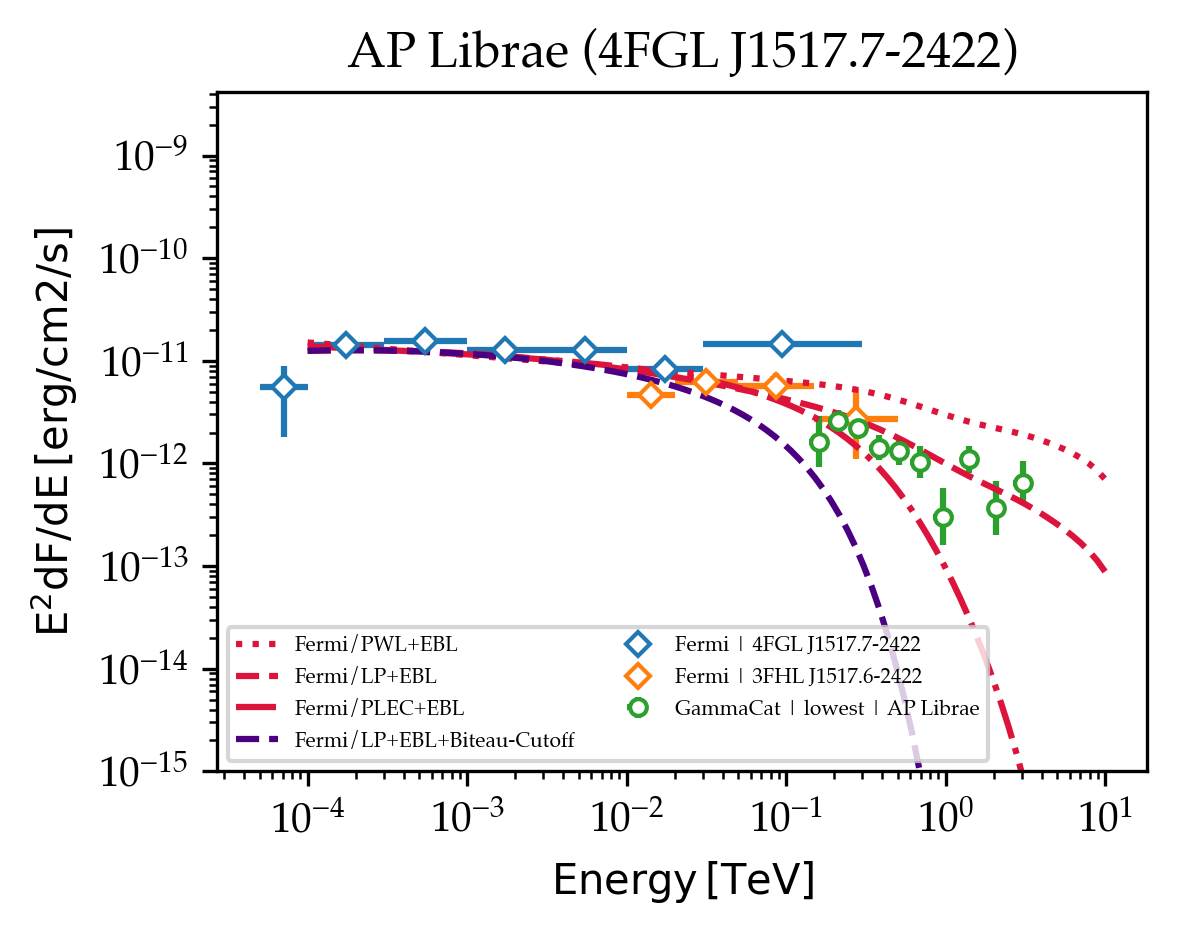

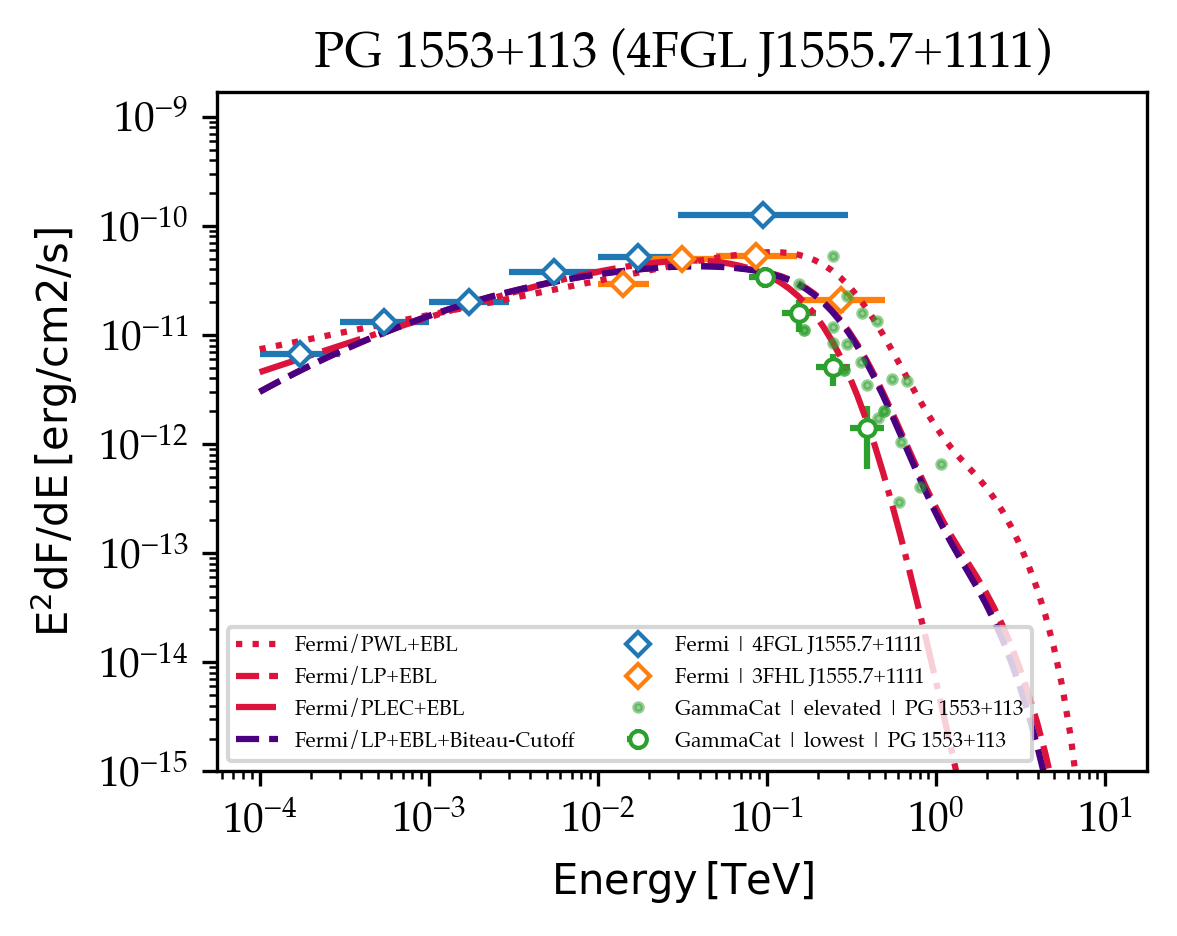

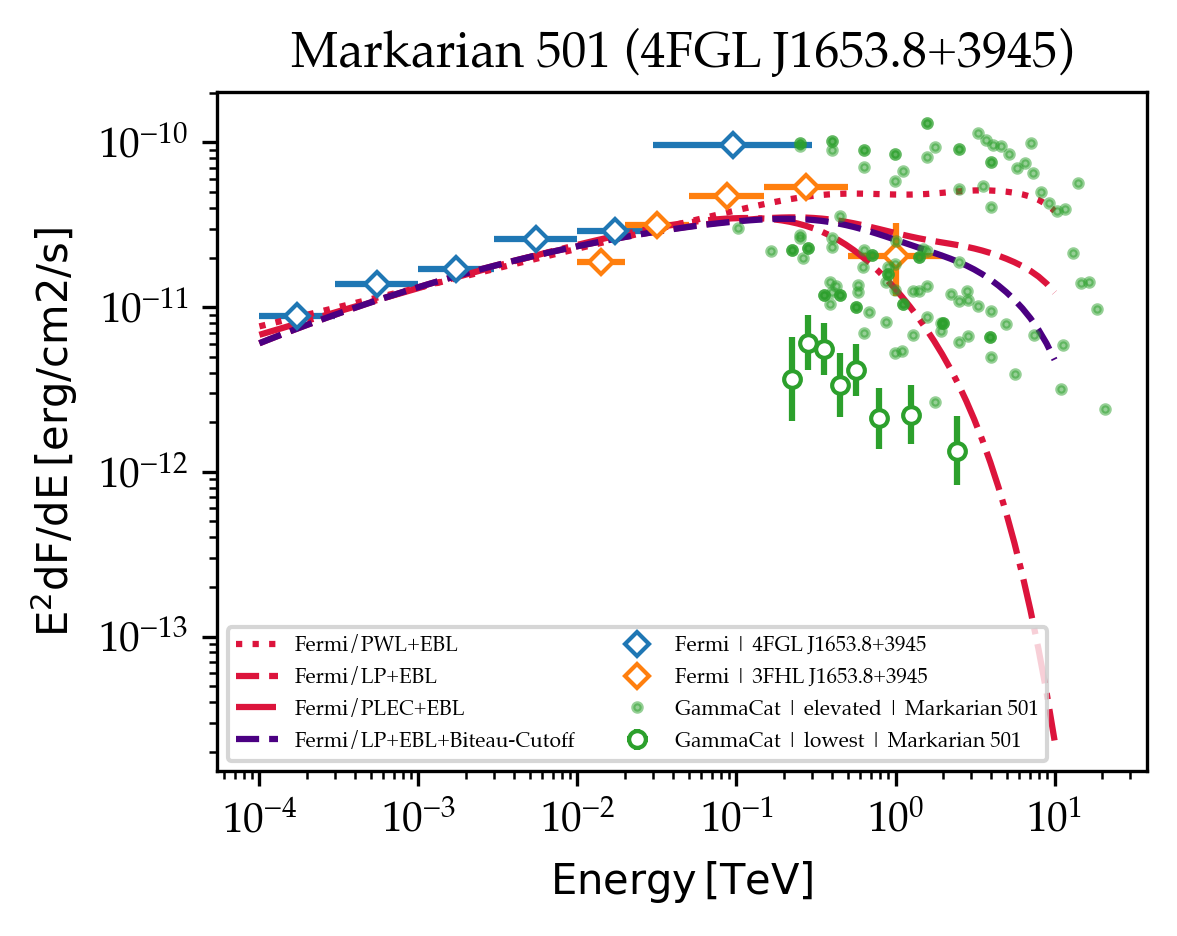

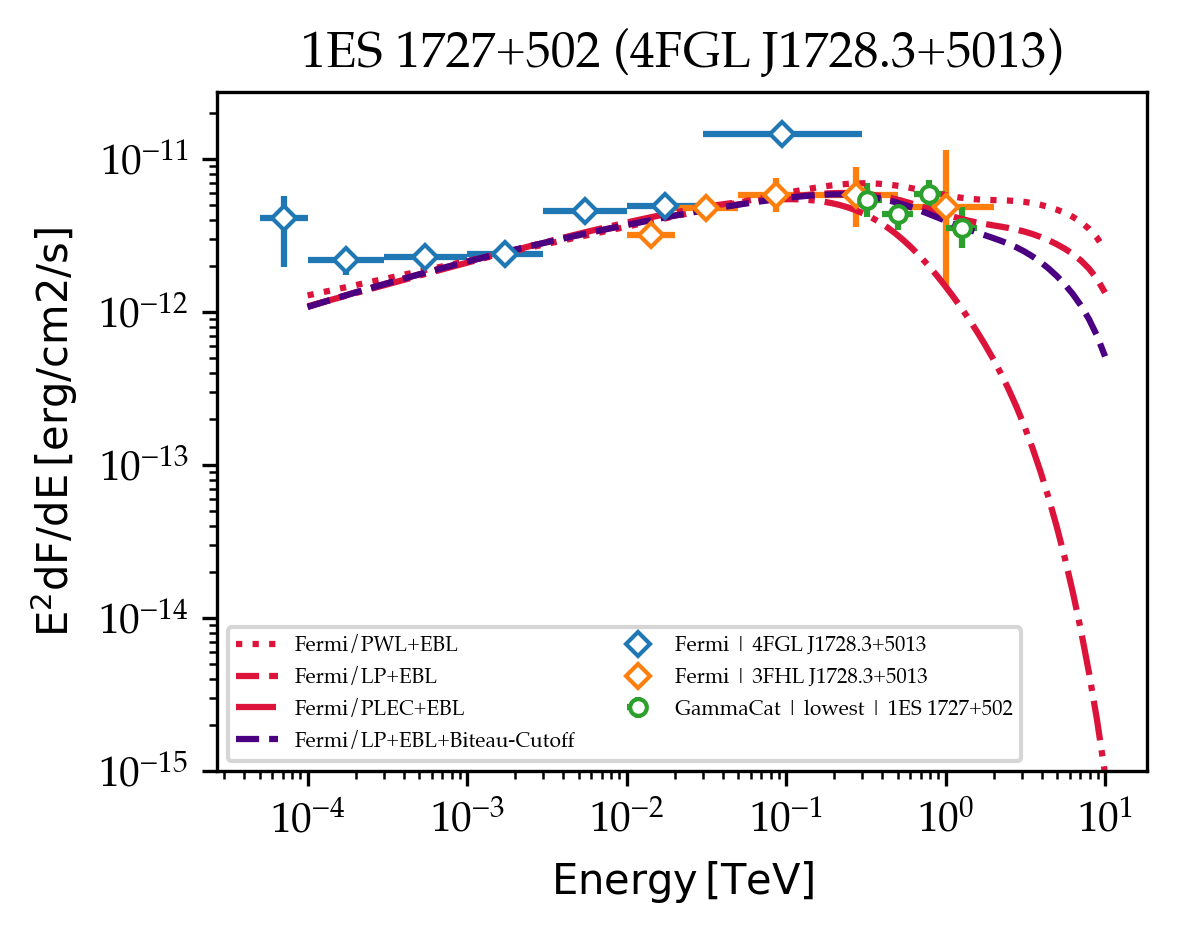

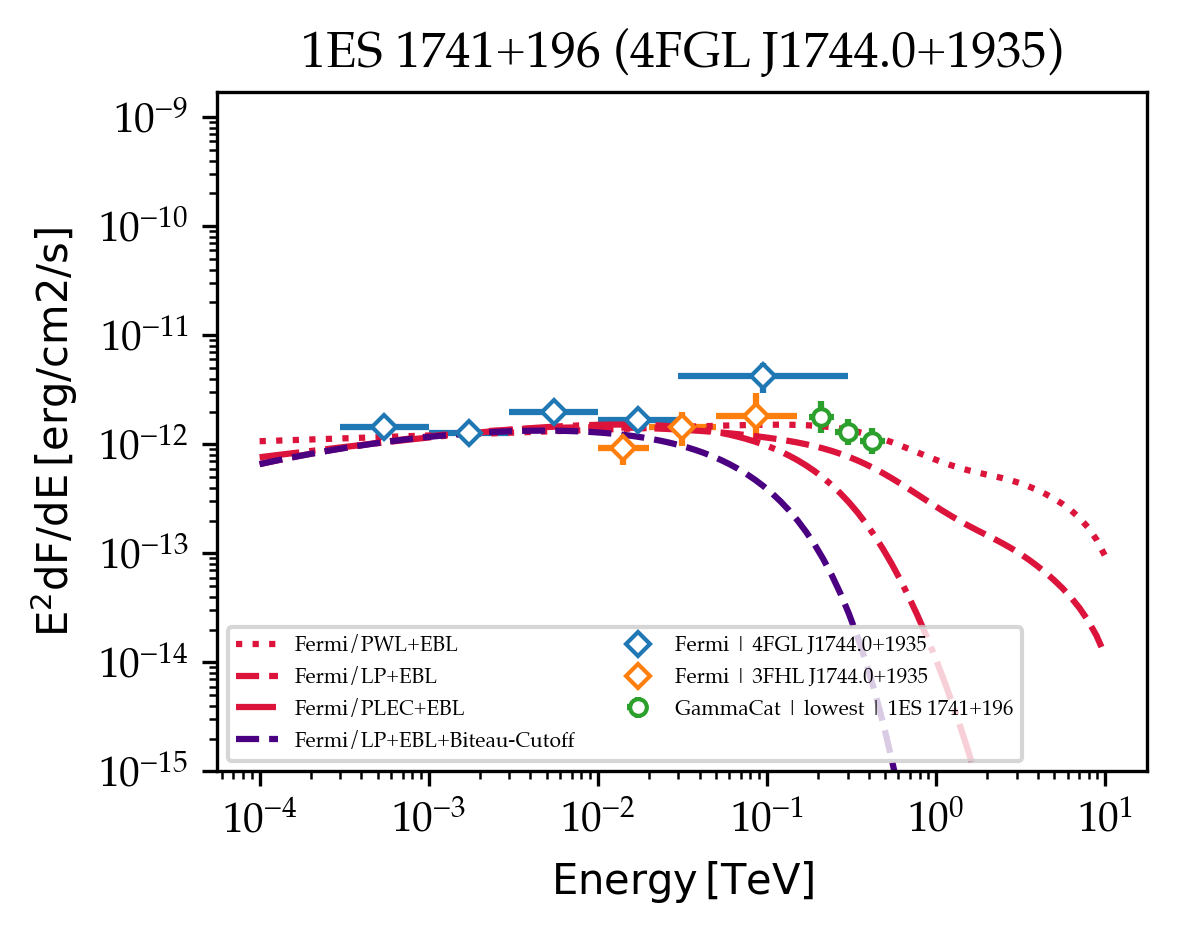

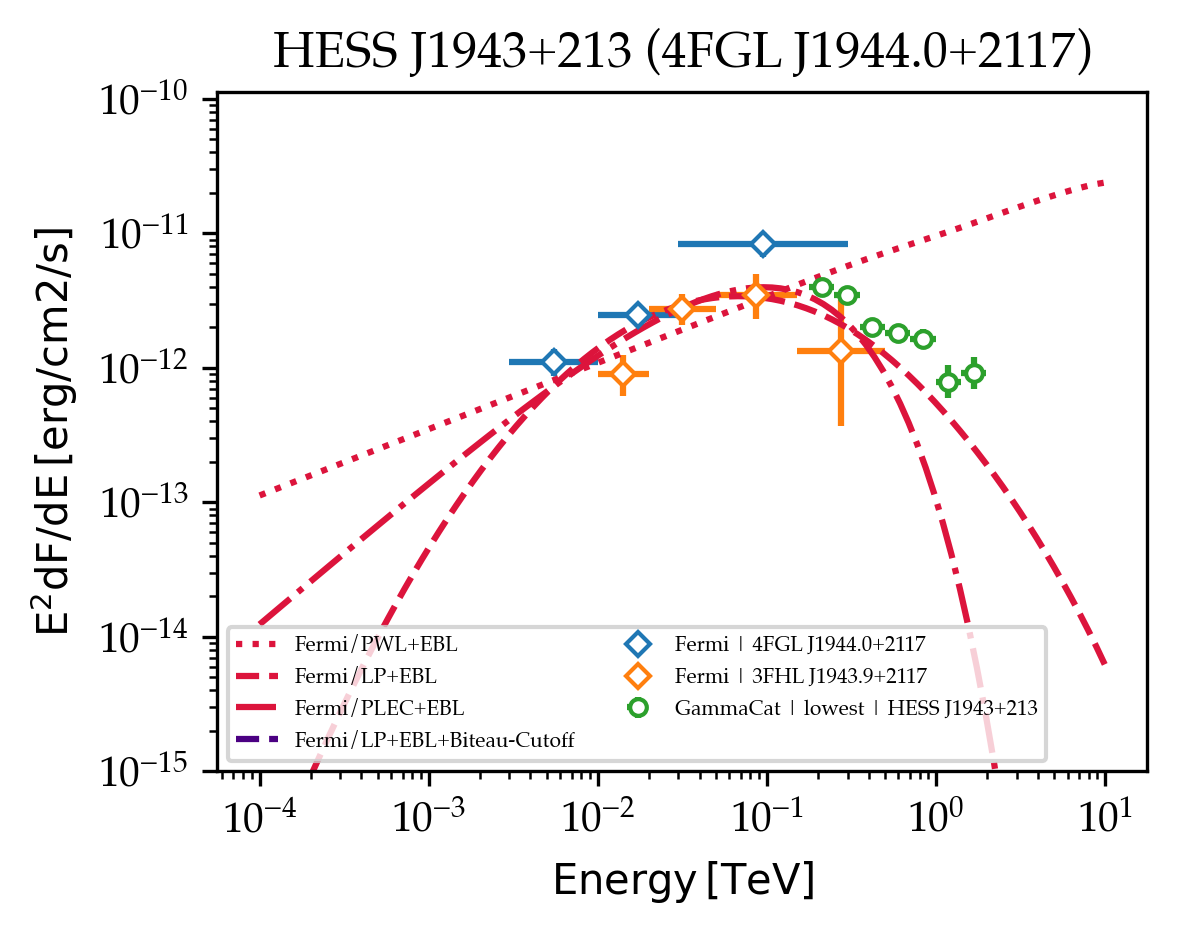

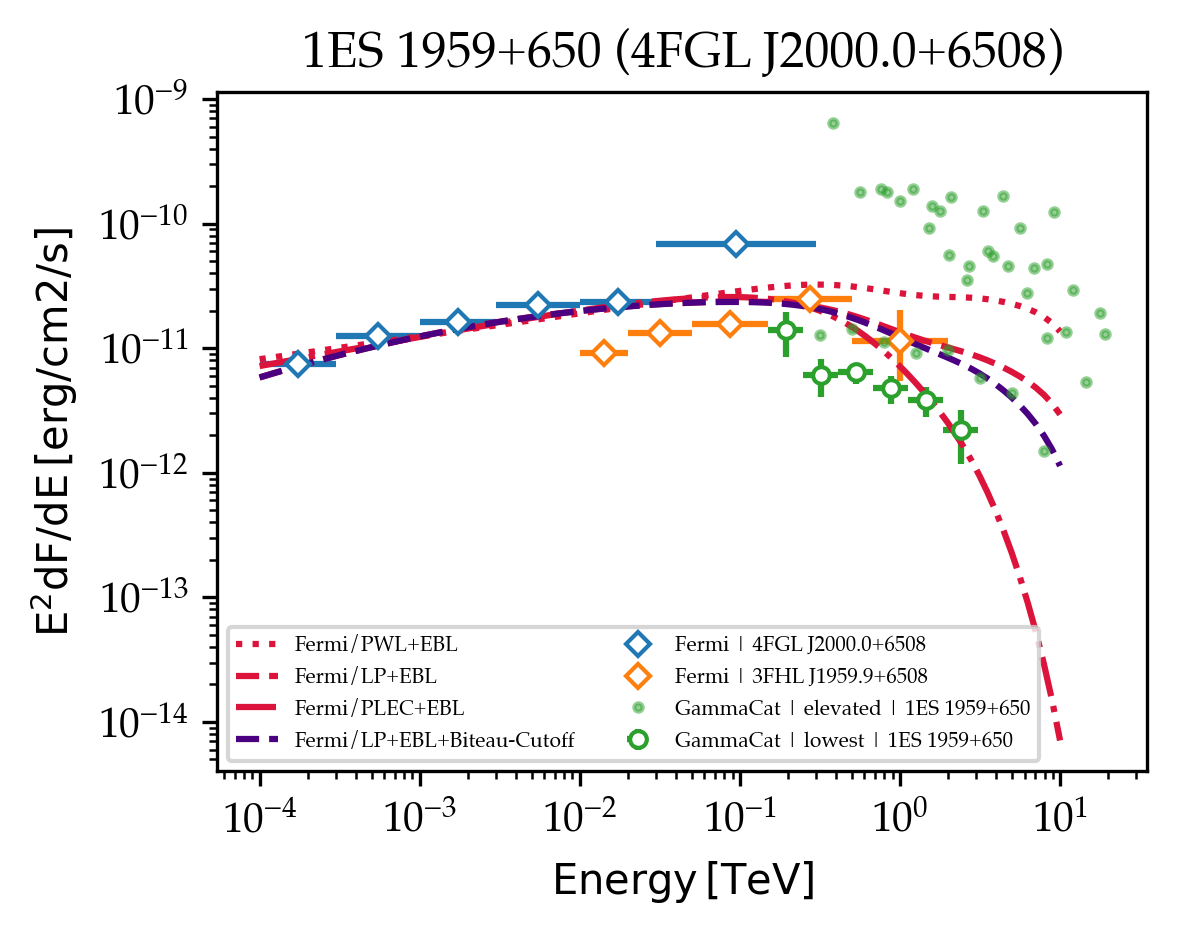

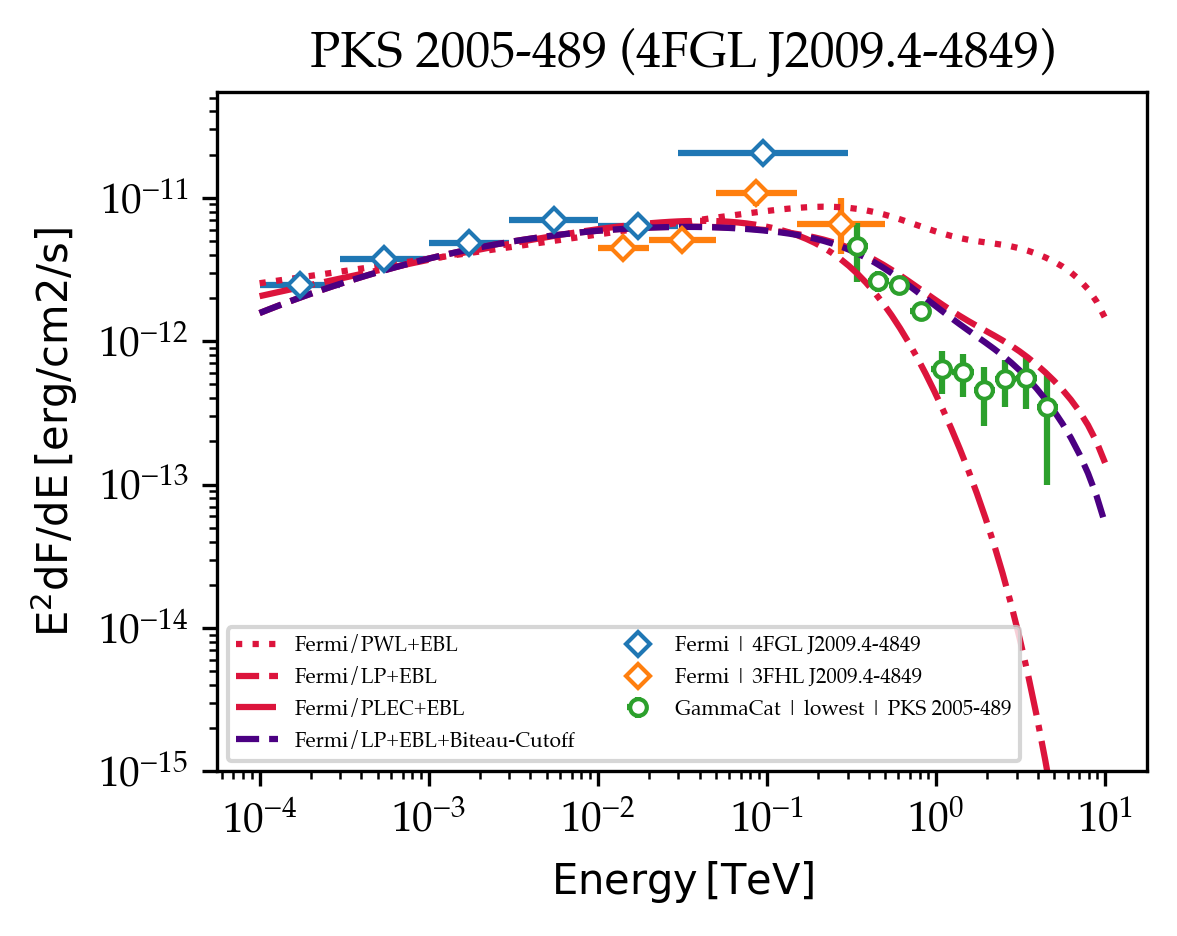

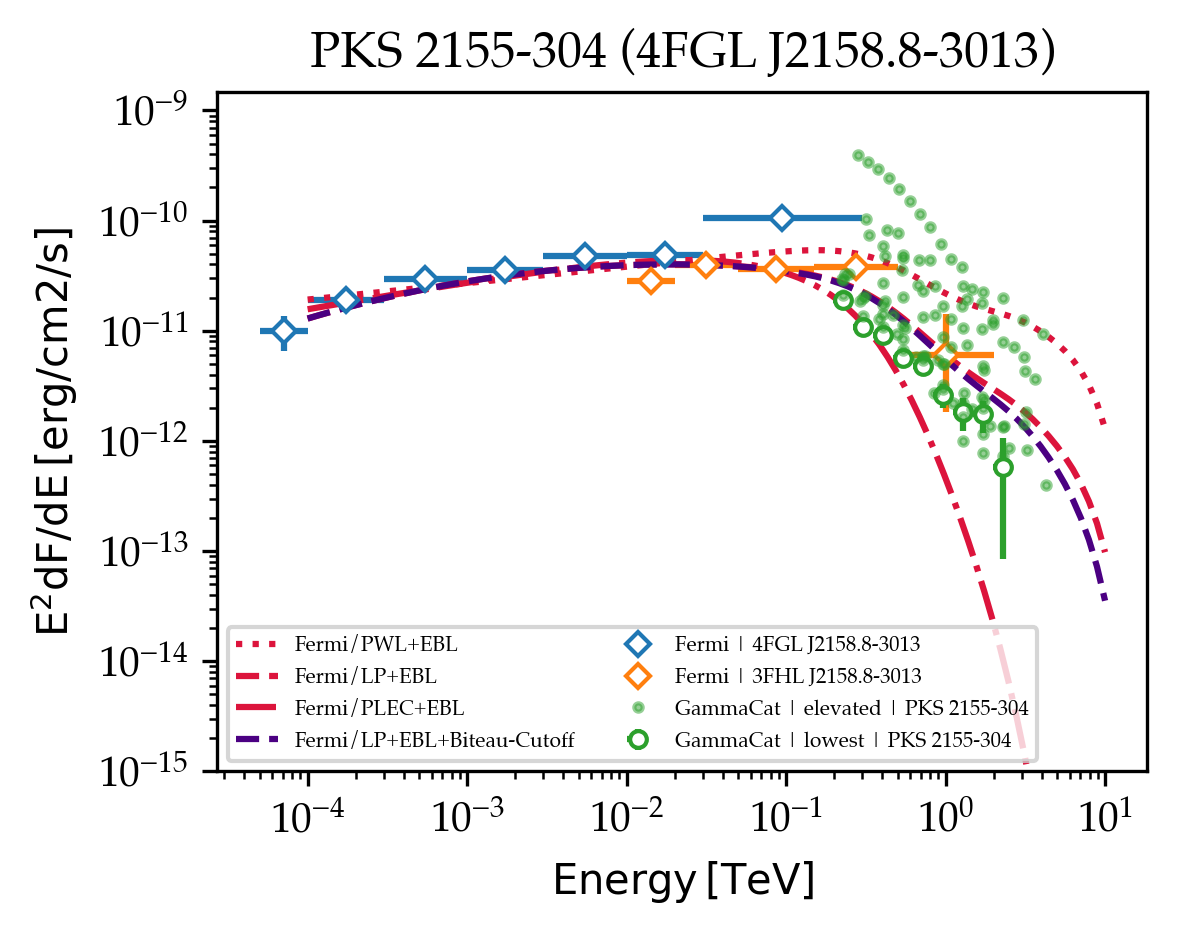

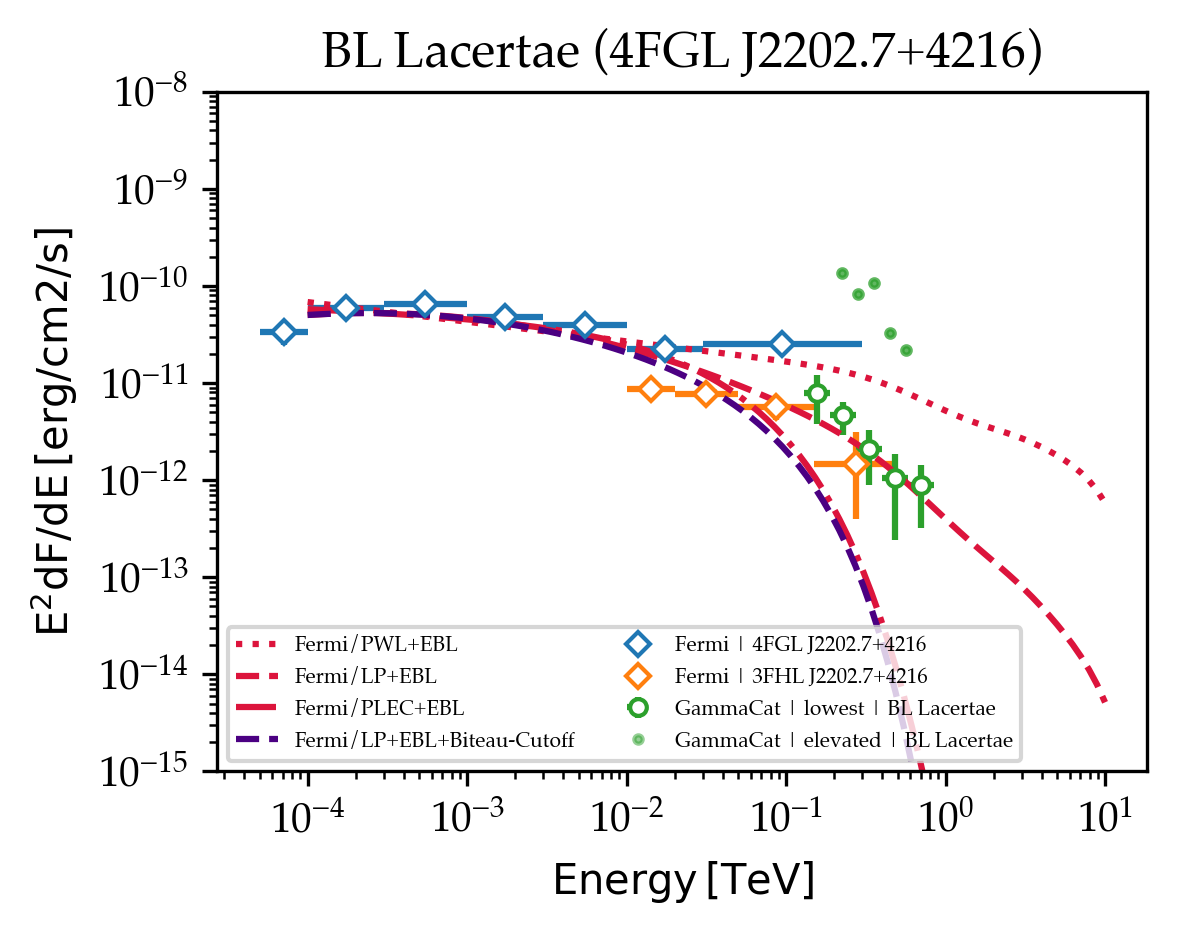

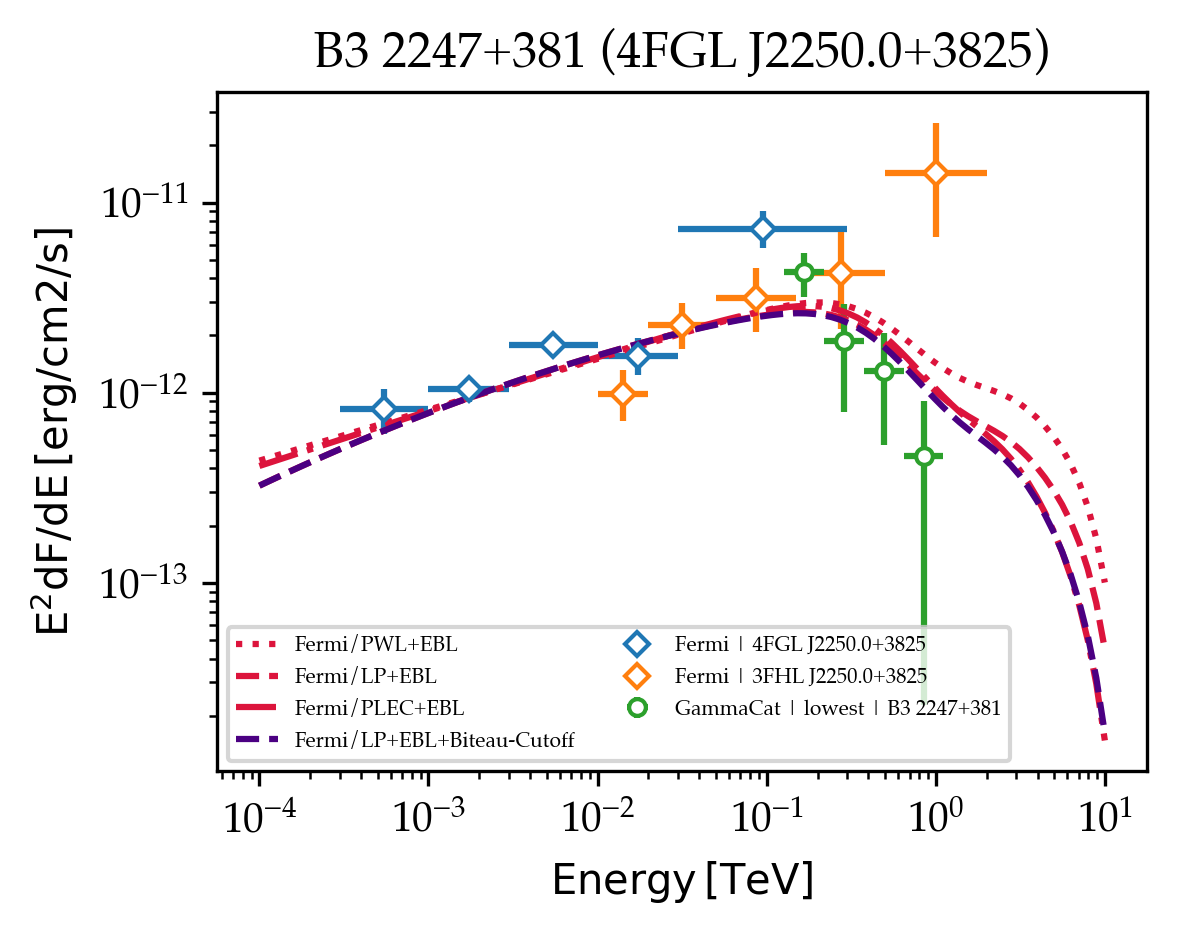

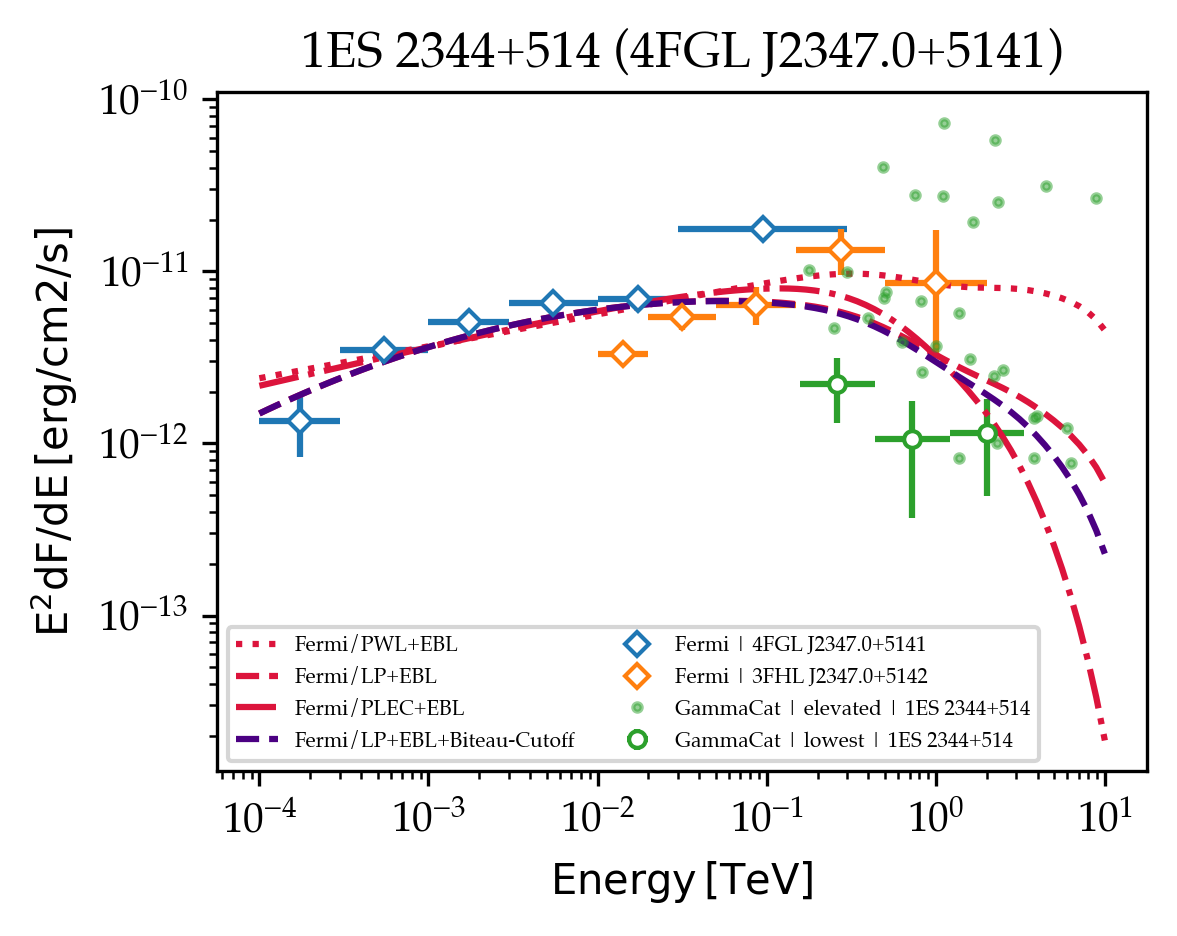

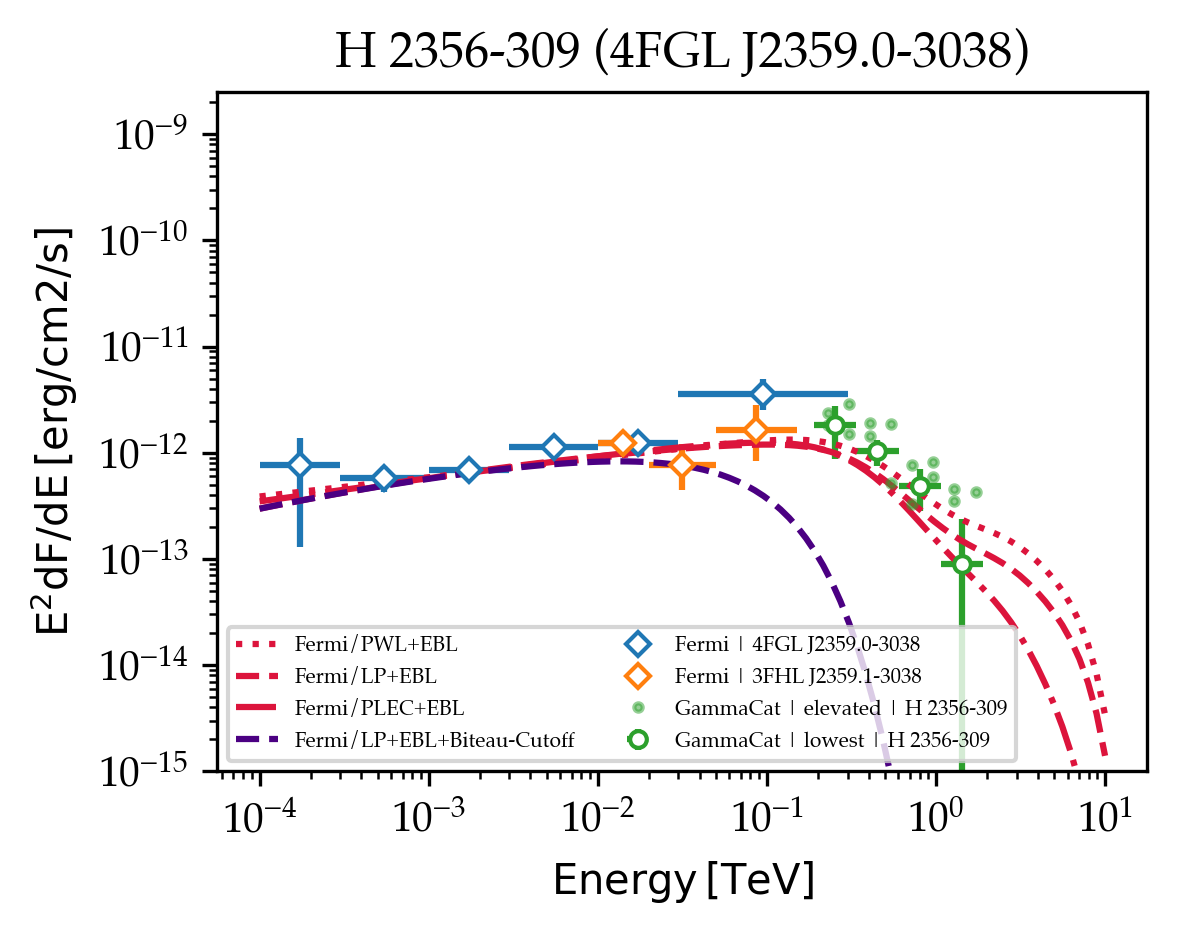

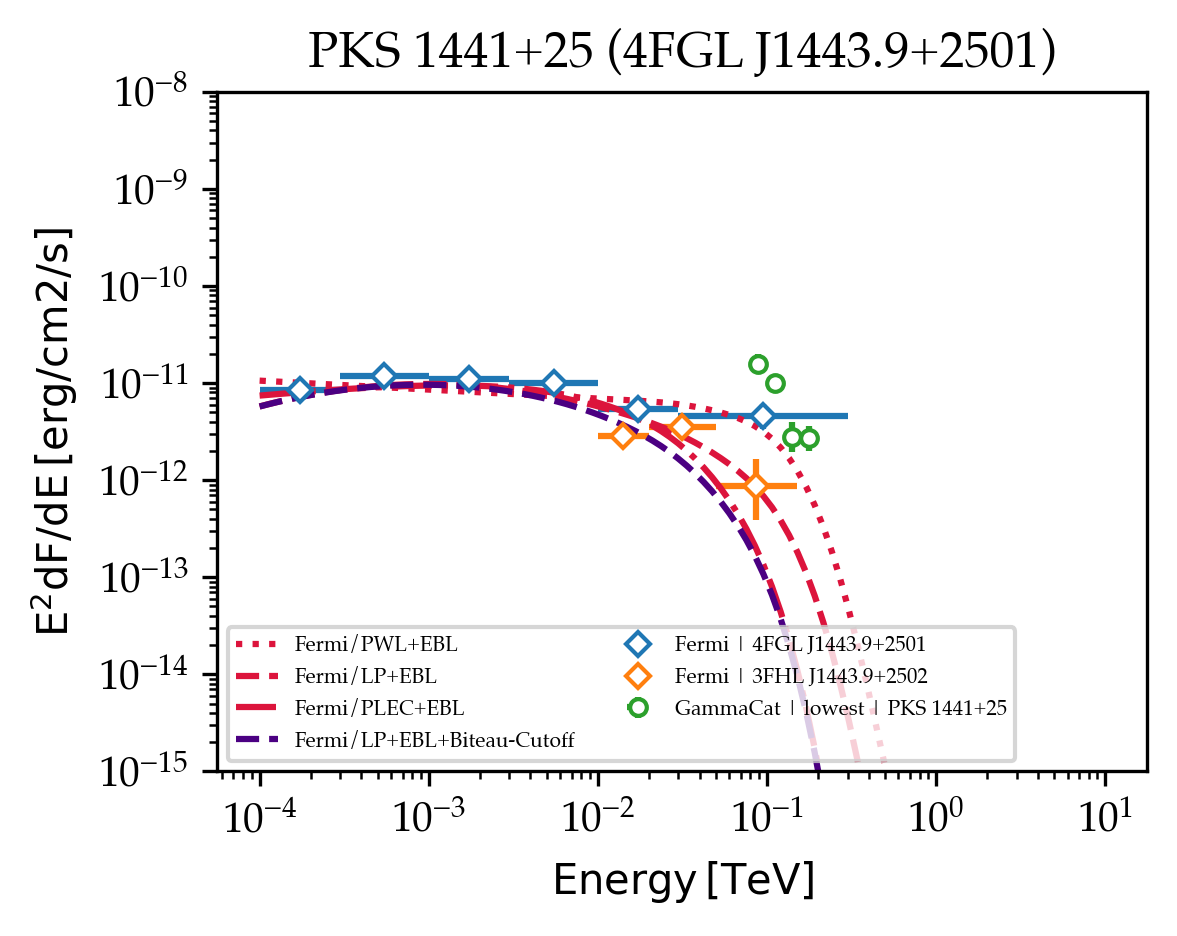

In [10]:
for _,k in enumerate(extragalactic):
    src = gammacat.contents[k]
    gammacat.reset_results()
    gammacat.match_src(src)
    gammacat.get_spectralpoints()
    
    fermicat3fhl.reset_results()
    fermicat3fhl.reset_spectral_points()
    fermicat3fhl.set_active_catalog("3FHL")
    fermicat3fhl.match_src(src)
    fermicat3fhl.fill_spectrum()
    fermicat3fhl.get_properties()
    
    fermicat.reset_results()
    fermicat.reset_spectral_points()
    fermicat.set_active_catalog("4FGL")
    fermicat.match_src(src)
    fermicat.fill_spectrum()
    fermicat.extract_model_parameters()
    fermicat.get_properties()
    
    mpl.rcParams['text.usetex'] = False
    myfitter = Fitter()
    myfitter.add_fermi(fermicat.result)
    myfitter.add_fermi2(fermicat3fhl.result)
    myfitter.add_vhe(gammacat.results)
    myfitter.build_broadband_spectra()
    myfitter.set_model_redshift(fermicat.result['redshift'])
    myfitter.set_model_spectralclass(fermicat.result['class'])
    myfitter.create_figure()
    myfitter.get_state()
    myfitter.plot_fermi_data()
    myfitter.plot_vhe_data()
    myfitter.predefined_models(residuals)
    myfitter.finish_figure()
    myfitter.savefig()

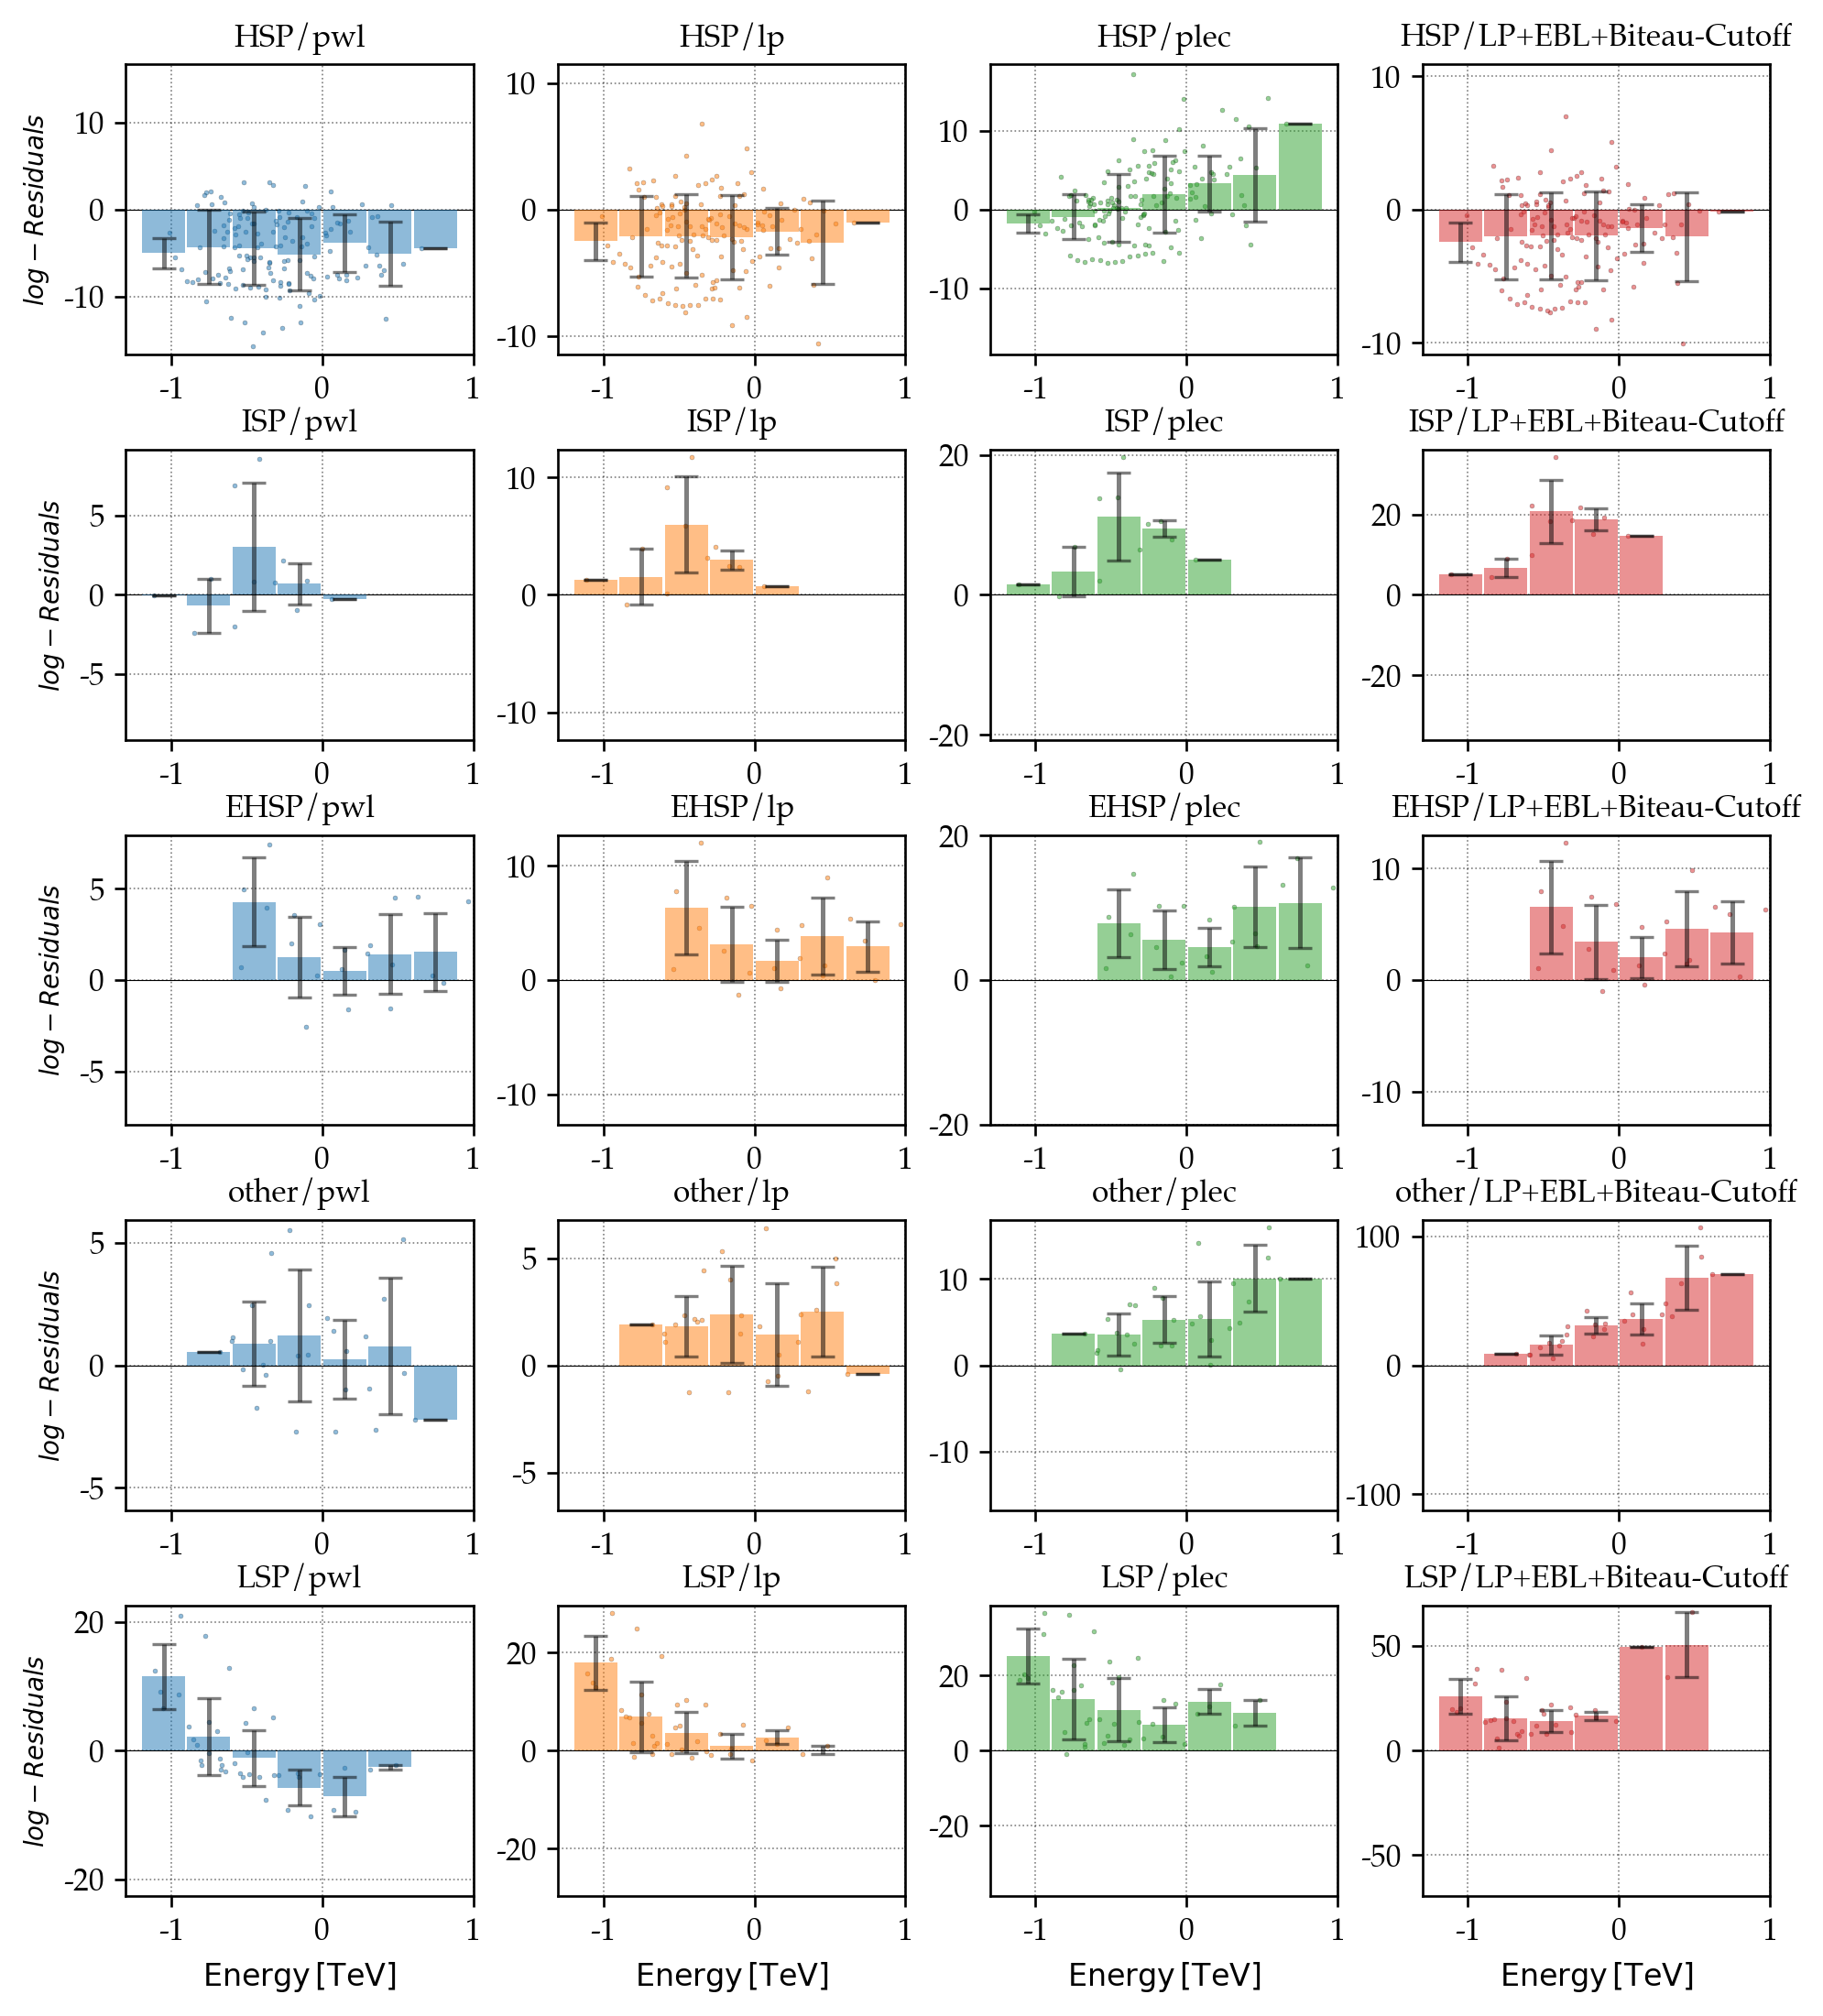

In [11]:
residuals.create_figure()
residuals.plot_panels()
residuals.savefig()

## VTScat

Read VTS cat and extract the spectra from all the results

In [17]:
vtscatsourcedir = "/Users/mnievas/Downloads/VTSCat-1.0-alpha"

In [18]:
!ls /Users/mnievas/Downloads/VTSCat-1.0-alpha

2008                  2017                  README.pub.md
2009                  2018                  ReviewerTable.md
2010                  2019                  Reviewing.md
2011                  2020                  SpectralModels.md
2012                  ADSdata               documents
2013                  Formats_and_Models.md publish.sh
2014                  How-to-submit-data.md scripts
2015                  PublicationTable.md   sources
2016                  README.md             sources_vtscat


In [22]:
!ls /Users/mnievas/Downloads/VTSCat-1.0-alpha/sources_vtscat

README.md       tev-000040.yaml tev-000119.yaml tev-000171.yaml tev-100183.yaml
tev-000001.yaml tev-000043.yaml tev-000132.yaml tev-000172.yaml tev-100184.yaml
tev-000003.yaml tev-000049.yaml tev-000136.yaml tev-000173.yaml tev-100185.yaml
tev-000007.yaml tev-000053.yaml tev-000137.yaml tev-000174.yaml tev-100186.yaml
tev-000011.yaml tev-000054.yaml tev-000138.yaml tev-100168.yaml tev-100187.yaml
tev-000013.yaml tev-000055.yaml tev-000141.yaml tev-100169.yaml tev-100189.yaml
tev-000014.yaml tev-000057.yaml tev-000143.yaml tev-100171.yaml tev-100190.yaml
tev-000017.yaml tev-000058.yaml tev-000144.yaml tev-100172.yaml tev-100191.yaml
tev-000018.yaml tev-000067.yaml tev-000146.yaml tev-100173.yaml tev-100192.yaml
tev-000020.yaml tev-000069.yaml tev-000148.yaml tev-100174.yaml tev-100193.yaml
tev-000022.yaml tev-000071.yaml tev-000149.yaml tev-100175.yaml tev-100194.yaml
tev-000023.yaml tev-000082.yaml tev-000153.yaml tev-100176.yaml tev-100195.yaml
tev-000025.yaml tev-000091.yaml tev-0001

In [87]:
!cat /Users/mnievas/Downloads/VTSCat-1.0-alpha/sources_vtscat/tev-000014.yaml

---
source_id: 14
common_name: LS I +61 303
gamma_names:
- VER J0240+612
other_names: []
where: gal
pos:
  simbad_id: LS I +61 303
  ra: 40.131938163
  dec: 61.229336515
reference_id:
- 2008ApJ...679.1427A


In [61]:
!ls /Users/mnievas/Downloads/VTSCat-1.0-alpha/2011/2011ApJ...726...43A/

1011.1053.pdf            VER-000011-lc-1.ecsv     data
Abdo_2011_ApJ_726_43.pdf VER-000011-lc-2.ecsv     figures
README.md                VER-000011-sed-1.ecsv    info.yaml
VER-000011-1.yaml        VER-000011-sed-2.ecsv
VER-000011-2.yaml        bibtex.bib


In [101]:
vtscatsourcedir

'/Users/mnievas/Downloads/VTSCat-1.0-alpha'

In [134]:
import glob
vts_sources_yamls = sorted(glob.glob(vtscatsourcedir+"/sources_vtscat/tev-*.yaml"))

In [135]:
VTS_srcs = {}
for fn in vts_sources_yamls:
    with open(fn) as f:
        YAMLcontents = yaml.load(f.read())
        try:
            YAMLcontents['where'] #=='egal')
        except:
            pass
        else:
            VTS_srcs[YAMLcontents['source_id']]=YAMLcontents

In [136]:
list_of_papers = sorted(glob.glob(vtscatsourcedir+"/20*/*"))
list_of_seds = sorted(glob.glob(vtscatsourcedir+"/20*/*/*-sed*.ecsv"))
list_of_lcs = sorted(glob.glob(vtscatsourcedir+"/20*/*/*-lc*.ecsv"))

In [137]:
!cat /Users/mnievas/Downloads/VTSCat-1.0-alpha/2008/2008ApJ...679..397A/VER-000058-lc.ecsv

# %ECSV 0.9
# ---
# datatype:
# - {name: e_min, unit: TeV, datatype: float64}
# - {name: time, unit: MJD, datatype: float64}
# - {name: flux, unit: m-2 s-1, datatype: float64}
# - {name: flux_err, unit: m-2 s-1, datatype: float64}
# meta: !!omap
# - data_type: lc
# - source_id: 58
# - reference_id: 2008ApJ...679..397A
# - telescope: veritas
# - data_source:
#   - digitizer
# - comments: |
e_min time flux flux_err
0.25     54143.512     45.763e-9     35.169e-9
0.25     54146.363     36.017e-9     19.068e-9
0.25     54147.242     -11.017e-9     28.814e-9
0.25     54148.449     53.814e-9     23.729e-9
0.25     54152.398     71.610e-9     26.695e-9
0.25     54153.387     -0.847e-9     37.712e-9
0.25     54154.484     17.797e-9     22.881e-9
0.25     54156.566     75.000e-9     29.661e-9
0.25     54171.379     17.373e-9     19.492e-9
0.25     54172.367     13.136e-9     22.034e-9
0.25     54173.355     77.542e-9     21.186e-9
0.25     54174.340     -2.542e-9     29.237e-9
0.25     54175.328

In [138]:
for sedfile in list_of_seds:
    sed = Table.read(sedfile, format='ascii.ecsv')
    sed_raw = open(sedfile).read()
    if sed.meta['source_id'] not in VTS_egal_srcs:
        continue
    
    src_dict = VTS_srcs[sed.meta['source_id']]
    try:
        src_dict['seds'].append(sed_raw)
    except KeyError:
        src_dict['seds'] = [sed_raw]

for lcfile in list_of_lcs:
    lc = Table.read(lcfile, format='ascii.ecsv')
    lc_raw = open(lcfile).read()
    if lc.meta['source_id'] not in VTS_srcs:
        continue
    
    src_dict = VTS_srcs[sed.meta['source_id']]
    try:
        src_dict['lcs'].append(lc_raw)
    except KeyError:
        src_dict['lcs'] = [lc_raw]
        
with open("/Users/mnievas/Software/cta/ext2TeV/ext2TeV/data/vtscat_reduced_v0.1a_20210423.yaml", "w+") as f:
    yaml.dump(VTS_srcs,f)

In [73]:
list_of_seds[0]

'/Users/mnievas/Downloads/VTSCat-1.0-alpha/2008/2008ApJ...679..397A/VER-000058-sed.ecsv'

In [77]:
sed.meta['source_id']

58

In [78]:
sed.meta

OrderedDict([('data_type', 'sed'),
             ('source_id', 58),
             ('reference_id', '2008ApJ...679..397A'),
             ('telescope', 'veritas'),
             ('comments', 'Table 1')])